# Preprocesamiento General del Dataset

---

## Trabajo Fin de Máster (TFM)
**Máster en Analítica de Datos en Marketing Digital**  
**Título del TFM**: *Análisis predictivo del comportamiento del consumidor a través del análisis de datos*

---

## Objetivo del notebook

El objetivo de este notebook es construir una **Tabla Maestra Limpia** a partir del dataset original `Full_Customer_Event_Data`, realizando los procesos de:

- **Limpieza básica** de columnas y registros innecesarios o inconsistentes.
- **Tratamiento de outliers** mediante winsorización en variables numéricas.
- **Agrupación de variables categóricas** para reducir cardinalidad y ruido.
- **Creación de variables estables** (como `has_promo`) para posteriores análisis.
- **Preparación de un dataset base robusto** para su posterior uso en flujos de predicción y segmentación.

---

## Enfoque

- **Las variables derivadas específicas** (ratios, ticket medio, indicadores de promociones) **se crearán más adelante en los datasets específicos** (`dataset_prediccion` y `dataset_segmentacion`).
- **La codificación** (One-Hot, Target Encoding) **se aplicará únicamente tras crear los datasets específicos**.
- Esta tabla maestra actuará como **base estable** para todo el proceso de análisis y modelado posterior.

---

## 1: Preparacion inicial

En este primer paso realizamos:

- Importación de librerías necesarias,
- Configuración de conexión a la base de datos PostgreSQL,
- Carga inicial del dataset `Full_Customer_Event_Data`.

Todo preparado para comenzar el preprocesamiento general.

---

In [1]:
import pandas as pd
from sqlalchemy import create_engine,text
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar variables de entorno
load_dotenv(override=True)

# Configuración de conexión
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_PORT = os.getenv("DB_PORT")

# Crear el motor de conexión a PostgreSQL
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

## 2: Limpieza básica de columnas

---

### Objetivo

Reducir el dataset `Full_Customer_Event_Data` a un conjunto de variables realmente relevantes para el análisis, eliminando:

- Datos personales que no aportan valor analítico,
- Identificadores técnicos que no son necesarios para trazabilidad,
- Variables redundantes o no discriminativas.

Todo esto respetando la trazabilidad mínima necesaria (`customer_id`, `event_id`, `session_id`) para posteriores análisis y auditorías.

---

### Decisiones tomadas

| Decisión | Justificación |
|:---------|:--------------|
| **Mantener identificadores analíticos** (`customer_id`, `event_id`, `session_id`) | Garantizan la trazabilidad entre eventos, sesiones y clientes sin introducir riesgos de privacidad. |
| **Eliminar datos personales** (`first_name`, `last_name`, `email`, `username`) | No aportan valor predictivo ni descriptivo, y suponen un riesgo innecesario para la privacidad. |
| **Eliminar identificadores técnicos** (`device_id`, `device_version`) | Variables puramente técnicas, de alta dispersión o sin procesamiento específico, que no aportan valor analítico. |
| **Eliminar `home_country`** | El 97% de los registros pertenecen a Indonesia, por lo que no aporta valor discriminativo al análisis. |
| **Conservar variables económicas, categóricas y geográficas relevantes** | Variables como `item_price`, `product_quantity`, `articletype`, `home_location_lat`, `home_location_long`, etc., son esenciales para el modelado, la segmentación y el análisis espacial. |

---

### Variables eliminadas en este paso

- `first_name`
- `last_name`
- `email`
- `username`
- `device_id`
- `device_version`
- `home_country`

---

### Tratamiento específico de variables geográficas

| Variable | Decisión | Justificación |
|:---------|:---------|:--------------|
| `home_location` | Mantener | Puede ser útil para segmentaciones regionales o visualizaciones |
| `home_location_lat`, `home_location_long` | Mantener | Permiten realizar clustering espacial y análisis geográfico |
| `shipment_location_lat`, `shipment_location_long` | Mantener | Opcional para análisis de destinos de envío |

---

### Resultado esperado

Se obtiene una **tabla física** (`Cleaned_Base_Table`) que:

- Conserva todos los datos relevantes para el análisis y la trazabilidad,
- Elimina cualquier variable que pueda comprometer la privacidad o introducir ruido técnico,
- Optimiza el rendimiento y la claridad del dataset para el tratamiento de outliers, transformación de variables y construcción de datasets analíticos posteriores.

---

> Con esta limpieza básica se establece una base sólida, ética y eficiente para todo el proceso de preprocesamiento, análisis predictivo y segmentación del TFM.

---


In [14]:
%%time
# 1. Consulta SQL para crear la tabla limpia
query_create_clean_base_table = """
DROP TABLE IF EXISTS Cleaned_Base_Table;

CREATE TABLE Cleaned_Base_Table AS
SELECT 
    customer_id,
    home_location_lat,
    home_location_long,
    home_location,
    first_join_date,
    event_id,
    session_id,
    event_name,
    event_time,
    traffic_source,
    device_type,
    customer_gender,
    birthdate,
    product_id,
    product_quantity,
    item_price,
    was_purchased,
    cem_promo_code,
    cem_promo_amount,
    search_keywords,
    cem_payment_status,
    booking_id,
    transaction_time,
    payment_method,
    transaction_payment_status,
    transaction_promo_code,
    transaction_promo_amount,
    shipment_fee,
    shipment_date_limit,
    shipment_location_lat,
    shipment_location_long,
    total_amount,
    gender,
    mastercategory,
    subcategory,
    articletype,
    basecolour,
    season,
    year,
    usage,
    productdisplayname,
    image_url
FROM Full_Customer_Event_Data;
"""

# 2. Ejecutar la creación de la tabla limpia
with engine.begin() as conn:
    conn.execute(text(query_create_clean_base_table))

print("✅ Tabla 'Cleaned_Base_Table' creada correctamente, eliminando datos personales, variables técnicas y home_country.")

✅ Tabla 'Cleaned_Base_Table' creada correctamente, eliminando datos personales, variables técnicas y home_country.
CPU times: total: 15.6 ms
Wall time: 1min 4s


## 3: Tratamiento de outliers en variables numéricas

---

### Objetivo

Detectar y tratar valores atípicos (outliers) en las variables numéricas principales del dataset `Cleaned_Base_Table`,  
con el objetivo de:

- Reducir el impacto de valores extremos que puedan distorsionar el análisis o el modelado,
- Mejorar la estabilidad y la interpretabilidad de las variables económicas y cuantitativas,
- Garantizar una base numérica robusta para la construcción de datasets analíticos posteriores.

---

### Metodología

Se aplicará la **winsorización controlada** mediante el método del **rango intercuartílico (IQR)**:

- Se calcularán el primer cuartil (Q1) y el tercer cuartil (Q3) para cada variable.
- Se determinará el rango intercuartílico (IQR = Q3 - Q1).
- Se establecerá un **límite superior** de winsorización:
  - **Límite superior = Q3 + 1.5 × IQR**
- Los valores superiores al límite serán reemplazados por el valor del límite.

> Nota: No se aplicará winsorización por debajo del límite inferior (Q1 - 1.5 × IQR), ya que las variables analizadas son precios, cantidades o importes que naturalmente no pueden ser negativos.

---

### Variables numéricas seleccionadas para tratamiento

| Variable | Descripción |
|:---------|:------------|
| `item_price` | Precio unitario del producto |
| `product_quantity` | Número de unidades compradas |
| `shipment_fee` | Coste de envío |
| `transaction_promo_amount` | Importe del descuento promocional aplicado |
| `total_amount` | Importe total de la transacción |

---

### Resultado esperado

- Se generarán nuevas variables `*_winsorized` para cada variable tratada.
- Se preservará la variable original para trazabilidad y auditoría.
- Se creará una base numérica robusta para la posterior construcción de:
  - `total_amount_final`
  - Nuevas variables derivadas específicas para predicción o segmentación.

---

> Este tratamiento garantiza un control riguroso de los outliers, mejorando la estabilidad analítica sin eliminar registros ni distorsionar la realidad económica del dataset.

---


### 3.1 Winsorización de `item_price` y ajuste de `total_amount_winsorized`

---

#### Objetivo

Tratar los valores atípicos (outliers) en la variable `item_price`,  
y recalcular de manera coherente el importe total de la transacción (`total_amount_winsorized`),  
ajustando solo cuando se haya producido una compra (`was_purchased = TRUE`).

---

#### Procedimiento realizado

- **Cálculo de Q1, Q3 e IQR** para `item_price` utilizando consultas SQL sobre la tabla `Cleaned_Base_Table`.
- **Determinación del límite superior** de winsorización aplicando la fórmula:  
  **Límite = Q3 + 1.5 × IQR**.
- **Creación de la nueva columna** `item_price_winsorized`:
  - Si `item_price` supera el límite, se reemplaza por el valor del límite.
  - Si no, se mantiene el valor original.
- **Creación de la nueva columna** `total_amount_winsorized`:
  - Si `was_purchased = TRUE` y `item_price` supera el límite, se ajusta restando el exceso sobre la cantidad comprada.
  - En caso contrario, se conserva el `total_amount` original.

---

#### Resultado

- Se controlaron los valores extremos en `item_price`, preservando la estructura realista de precios.
- Se garantizó la coherencia del importe total (`total_amount_winsorized`) ajustando únicamente en transacciones efectivamente realizadas.
- Las columnas originales (`item_price`, `total_amount`) se mantuvieron intactas para asegurar trazabilidad.

---

> Este enfoque modular y controlado permite limpiar los outliers sin perder integridad económica, respetando el comportamiento real de los eventos de compra.

---


#### Análisis exploratorio previo de `item_price`

Antes de aplicar la winsorización, se realizó un análisis exploratorio de la distribución de `item_price`, con el objetivo de:

- Visualizar la concentración de valores,
- Identificar la magnitud y cantidad de outliers,
- Confirmar la necesidad y justificación del tratamiento.

Para ello, se utilizaron histogramas, boxplots y estadísticas descriptivas.

---


In [15]:
%%time
# Paso 1: obtener Q1 y Q3 desde SQL
query_stats = """
SELECT 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY item_price) AS q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY item_price) AS q3
FROM Cleaned_Base_Table
WHERE item_price IS NOT NULL;
"""
q1, q3 = pd.read_sql_query(query_stats, engine).iloc[0]

# Calcular umbral de outlier
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr

# Paso 2: contar outliers y total
query_outliers = f"""
SELECT 
    COUNT(*) FILTER (WHERE item_price > {upper_threshold}) AS total_outliers,
    COUNT(*) AS total_values,
    ROUND(100.0 * COUNT(*) FILTER (WHERE item_price > {upper_threshold}) / COUNT(*), 2) AS porcentaje_outliers
FROM Cleaned_Base_Table
WHERE item_price IS NOT NULL;
"""
df_outliers = pd.read_sql_query(query_outliers, engine)
df_outliers

CPU times: total: 0 ns
Wall time: 7.2 s


,total_outliers,total_values,porcentaje_outliers
0,36368,1937158,1.88


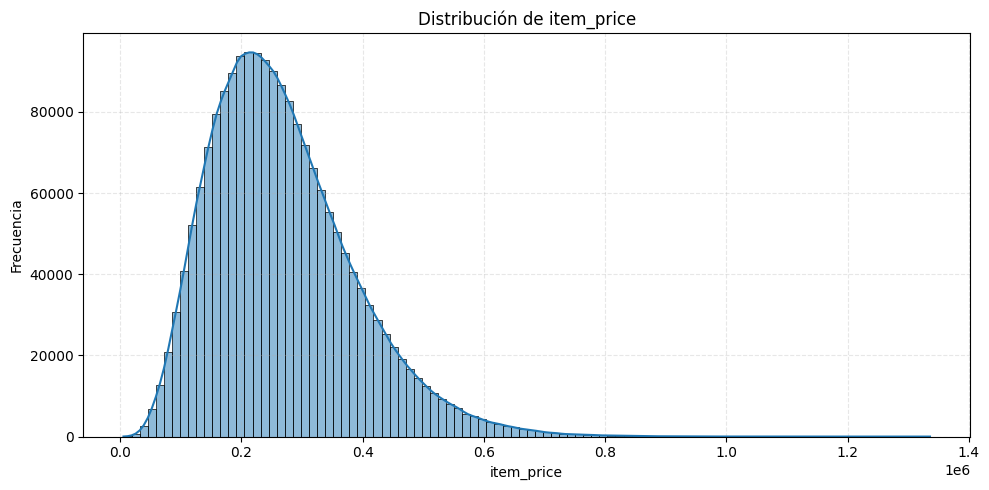

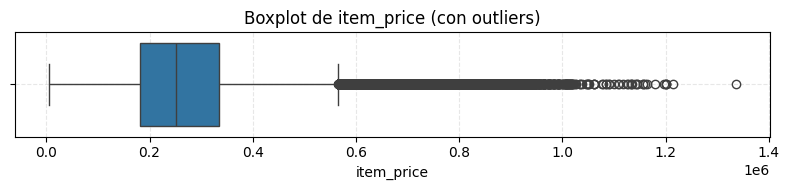

CPU times: total: 12.4 s
Wall time: 22 s


In [7]:
%%time
# Cargar solo la columna item_price desde la base de datos
query_item_price = """
SELECT item_price
FROM Cleaned_Base_Table
WHERE item_price IS NOT NULL;
"""

df_item_price = pd.read_sql_query(query_item_price, engine)
item_price_series = df_item_price['item_price']

# Histograma con KDE
plt.figure(figsize=(10, 5))
sns.histplot(item_price_series, bins=100, kde=True)
plt.title("Distribución de item_price")
plt.xlabel("item_price")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot para visualizar outliers
plt.figure(figsize=(8, 2))
sns.boxplot(x=item_price_series)
plt.title("Boxplot de item_price (con outliers)")
plt.xlabel("item_price")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#### Análisis cuantitativo de outliers en `item_price`

El análisis mostró que:

- Solo el 1,88% de los registros (36.368 casos) superaban el límite superior calculado mediante el método IQR.
- Aunque el porcentaje de outliers es relativamente bajo, la magnitud de los valores extremos justifica aplicar una winsorización superior para garantizar la estabilidad analítica.

Por tanto, se procede a crear la variable `item_price_winsorized`, limitando los valores extremos al umbral calculado.


In [15]:
%%time
# Paso 1: Obtener Q1 y Q3 desde Cleaned_Base_Table
query_stats = """
SELECT 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY item_price) AS q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY item_price) AS q3
FROM Cleaned_Base_Table
WHERE item_price IS NOT NULL;
"""
q1, q3 = pd.read_sql_query(query_stats, engine).iloc[0]

# Paso 2: Calcular IQR y límite superior
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr

print(f"item_price - Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}, Límite superior: {upper_threshold:.2f}")

# Paso 3: Crear columnas winsorizadas y actualizar en una sola consulta SQL
query_winsorize_item_price = f"""
-- Añadir columnas si no existen
ALTER TABLE Cleaned_Base_Table
ADD COLUMN IF NOT EXISTS item_price_winsorized DOUBLE PRECISION,
ADD COLUMN IF NOT EXISTS total_amount_winsorized DOUBLE PRECISION;

-- Añadir columnas si no existen
ALTER TABLE Cleaned_Base_Table
ADD COLUMN IF NOT EXISTS item_price_winsorized DOUBLE PRECISION,
ADD COLUMN IF NOT EXISTS total_amount_winsorized DOUBLE PRECISION;

-- Actualizar item_price_winsorized y total_amount_winsorized
UPDATE Cleaned_Base_Table
SET 
    item_price_winsorized = CASE
        WHEN item_price > {upper_threshold} THEN {upper_threshold}
        ELSE item_price
    END,
    
    total_amount_winsorized = CASE
        WHEN was_purchased = TRUE AND item_price > {upper_threshold}
        THEN total_amount - ((item_price - {upper_threshold}) * COALESCE(product_quantity, 1))
        ELSE total_amount
    END;
"""

# Ejecutar todo
with engine.begin() as conn:
    conn.execute(text(query_winsorize_item_price))

print("✅ item_price_winsorized y total_amount_winsorized creados y actualizados correctamente.")


# 4. Verificar registros modificados
query_check_modificados = f"""
SELECT COUNT(*) AS registros_modificados
FROM Cleaned_Base_Table
WHERE item_price_winsorized <> item_price;
"""
modificados = pd.read_sql_query(query_check_modificados, engine).iloc[0, 0]
print(f"Registros modificados por winsorización: {modificados}")

# 4. Verificar registros modificados
query_check_modificados = f"""
SELECT COUNT(*) AS registros_modificados
FROM Cleaned_Base_Table
WHERE item_price_winsorized <> item_price;
"""
modificados = pd.read_sql_query(query_check_modificados, engine).iloc[0, 0]
print(f"Registros modificados por winsorización: {modificados}")

item_price - Q1: 181535.00, Q3: 335410.00, IQR: 153875.00, Límite superior: 566222.50
✅ item_price_winsorized y total_amount_winsorized creados y actualizados correctamente.
Registros modificados por winsorización: 36368
Registros modificados por winsorización: 36368
CPU times: total: 0 ns
Wall time: 2min 32s


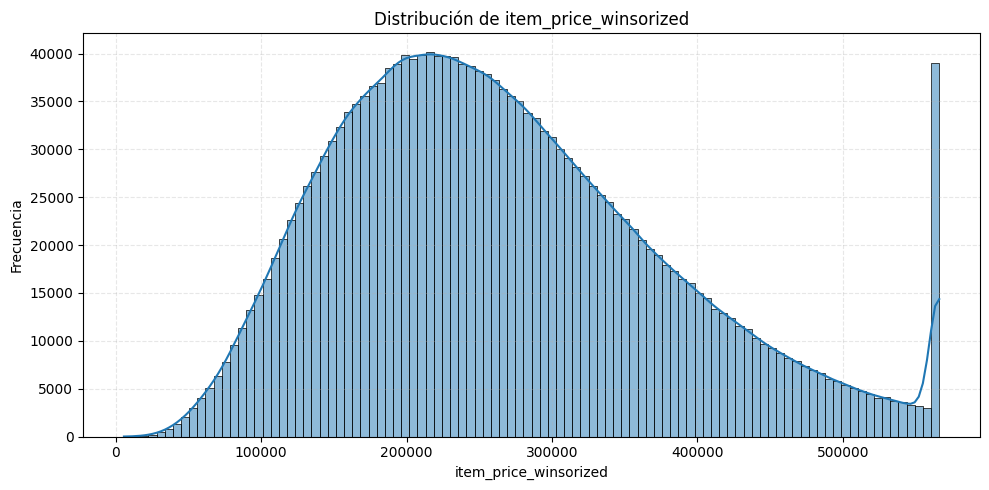

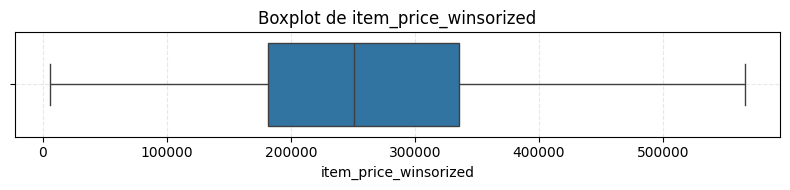

CPU times: total: 17.1 s
Wall time: 22.3 s


In [7]:
%%time
# Cargar solo la columna item_price desde la base de datos
query_item_price_winsorized = """
SELECT item_price_winsorized
FROM Cleaned_Base_Table
WHERE item_price_winsorized IS NOT NULL;
"""

df_item_price_winsorized = pd.read_sql_query(query_item_price_winsorized, engine)
item_price_winsorized_series = df_item_price_winsorized['item_price_winsorized']

# Histograma con KDE
plt.figure(figsize=(10, 5))
sns.histplot(item_price_winsorized_series, bins=100, kde=True)
plt.title("Distribución de item_price_winsorized")
plt.xlabel("item_price_winsorized")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot para visualizar outliers
plt.figure(figsize=(8, 2))
sns.boxplot(x=item_price_winsorized_series)
plt.title("Boxplot de item_price_winsorized")
plt.xlabel("item_price_winsorized")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2 Winsorización de `shipment_fee` y ajuste de `total_amount_winsorized`

---

#### Objetivo

Tratar los valores atípicos (outliers) en la variable `shipment_fee`,  
y recalcular de manera coherente el importe total de la transacción (`total_amount_winsorized`)  
ajustando únicamente cuando se detecten valores extremos.

---

#### Procedimiento realizado

- **Cálculo de Q1, Q3 e IQR** para `shipment_fee` utilizando consultas SQL sobre la tabla `Cleaned_Base_Table`.
- **Determinación del límite superior** de winsorización aplicando la fórmula:  
  **Límite = Q3 + 1.5 × IQR**.
- **Creación de la nueva columna** `shipment_fee_winsorized`:
  - Si `shipment_fee` supera el límite, se reemplaza por el valor del límite.
  - Si no, se mantiene el valor original.
- **Ajuste de `total_amount_winsorized`**:
  - Si `shipment_fee` supera el límite, se recalcula sumando la diferencia al importe total ya ajustado.

---

#### Resultado

- Se controlaron los valores extremos en `shipment_fee`.
- Se garantizó la coherencia del importe total (`total_amount_winsorized`), reflejando correctamente el coste de envío corregido.
- Se preservaron las columnas originales (`shipment_fee`) para trazabilidad.

---

> Este tratamiento modular de variables permite un control progresivo de los outliers en el dataset, asegurando estabilidad analítica sin sobrescribir datos originales.

---


In [8]:
%%time
# Paso 1: obtener Q1 y Q3 desde SQL
query_stats = """
SELECT 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY shipment_fee) AS q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY shipment_fee) AS q3
FROM Cleaned_Base_Table
WHERE shipment_fee IS NOT NULL;
"""
q1, q3 = pd.read_sql_query(query_stats, engine).iloc[0]

# Calcular umbral de outlier
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr

# Paso 2: contar outliers y total
query_outliers = f"""
SELECT 
    COUNT(*) FILTER (WHERE shipment_fee > {upper_threshold}) AS total_outliers,
    COUNT(*) AS total_values,
    ROUND(100.0 * COUNT(*) FILTER (WHERE shipment_fee > {upper_threshold}) / COUNT(*), 2) AS porcentaje_outliers
FROM Cleaned_Base_Table
WHERE shipment_fee IS NOT NULL;
"""
df_outliers = pd.read_sql_query(query_outliers, engine)
df_outliers

CPU times: total: 0 ns
Wall time: 8.31 s


,total_outliers,total_values,porcentaje_outliers
0,404147,12463005,3.24


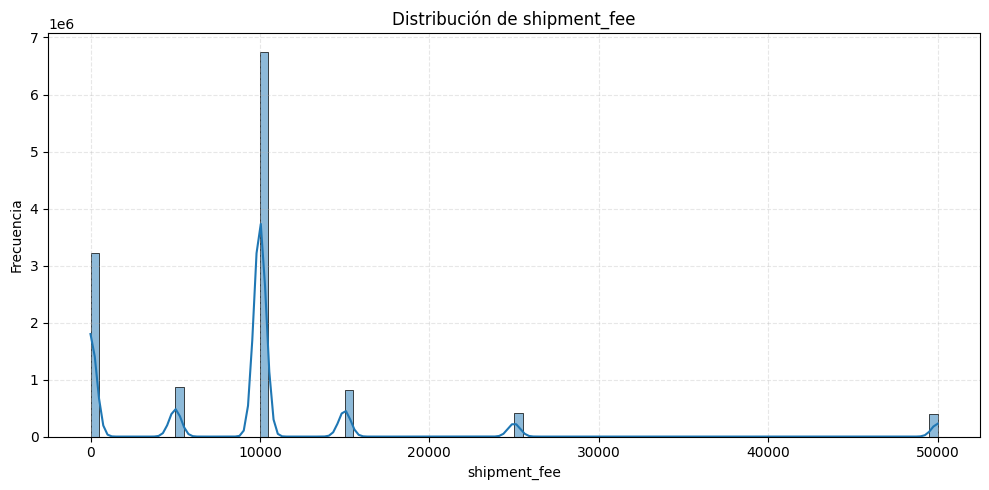

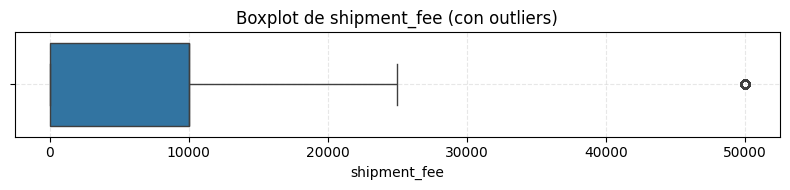

CPU times: total: 1min 18s
Wall time: 1min 23s


In [9]:
%%time
# Cargar solo la columna item_price desde la base de datos
query_shipment_fee = """
SELECT shipment_fee
FROM Cleaned_Base_Table
WHERE shipment_fee IS NOT NULL;
"""

df_shipment_fee = pd.read_sql_query(query_shipment_fee, engine)
shipment_fee_series = df_shipment_fee['shipment_fee']

# Histograma con KDE
plt.figure(figsize=(10, 5))
sns.histplot(shipment_fee_series, bins=100, kde=True)
plt.title("Distribución de shipment_fee")
plt.xlabel("shipment_fee")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot para visualizar outliers
plt.figure(figsize=(8, 2))
sns.boxplot(x=shipment_fee_series)
plt.title("Boxplot de shipment_fee (con outliers)")
plt.xlabel("shipment_fee")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#### Análisis cuantitativo de outliers en `shipment_fee`

El análisis mostró que:

- El 3,24% de los registros (404.147 casos) superaban el límite superior calculado mediante el método IQR.
- Dado el volumen absoluto de outliers y su impacto potencial sobre estadísticas y modelos, se consideró necesaria la aplicación de winsorización en `shipment_fee`.

Por tanto, se procederá a crear la variable `shipment_fee_winsorized`, limitando los valores superiores al umbral calculado.

El importe total de la transacción (`total_amount_winsorized`) será también ajustado para reflejar correctamente la corrección aplicada en los costes de envío.

---


In [16]:
%%time
# Paso 1: Calcular Q1 y Q3 desde Cleaned_Base_Table
query_stats_shipment_fee = """
SELECT 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY shipment_fee) AS q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY shipment_fee) AS q3
FROM Cleaned_Base_Table
WHERE shipment_fee IS NOT NULL;
"""
q1, q3 = pd.read_sql_query(query_stats_shipment_fee, engine).iloc[0]

# Paso 2: Calcular IQR y límite superior
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr

print(f"shipment_fee - Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}, Límite superior: {upper_threshold:.2f}")

# Paso 3: Crear columnas y actualizar en una sola consulta SQL
query_winsorize_shipment_fee = f"""
-- Añadir columna shipment_fee_winsorized si no existe
ALTER TABLE Cleaned_Base_Table
ADD COLUMN IF NOT EXISTS shipment_fee_winsorized DOUBLE PRECISION;

-- Actualizar shipment_fee_winsorized y ajustar total_amount_winsorized
UPDATE Cleaned_Base_Table
SET 
    shipment_fee_winsorized = CASE
        WHEN shipment_fee > {upper_threshold} THEN {upper_threshold}
        ELSE shipment_fee
    END,
    
    total_amount_winsorized = CASE
        WHEN was_purchased = TRUE AND shipment_fee > {upper_threshold}
        THEN total_amount_winsorized - shipment_fee + {upper_threshold}
        ELSE total_amount_winsorized
    END;
"""

# Ejecutar la actualización
with engine.begin() as conn:
    conn.execute(text(query_winsorize_shipment_fee))

print("✅ shipment_fee_winsorized creado y total_amount_winsorized ajustado correctamente.")

# 4. Verificar registros modificados
query_check_modificados = f"""
SELECT COUNT(*) AS registros_modificados
FROM Cleaned_Base_Table
WHERE shipment_fee_winsorized <> shipment_fee;
"""
modificados = pd.read_sql_query(query_check_modificados, engine).iloc[0, 0]
print(f"Registros modificados por winsorización: {modificados}")

shipment_fee - Q1: 0.00, Q3: 10000.00, IQR: 10000.00, Límite superior: 25000.00
✅ shipment_fee_winsorized creado y total_amount_winsorized ajustado correctamente.
Registros modificados por winsorización: 404147
CPU times: total: 15.6 ms
Wall time: 2min 47s


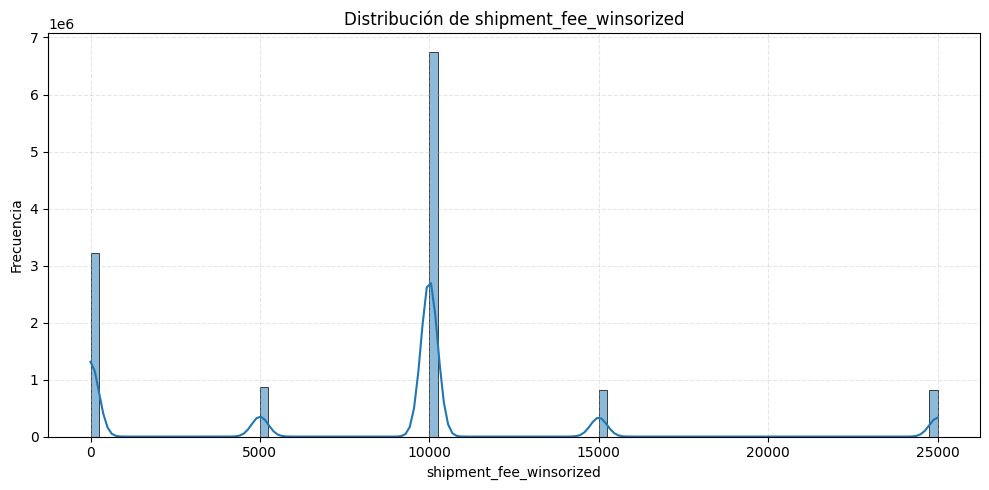

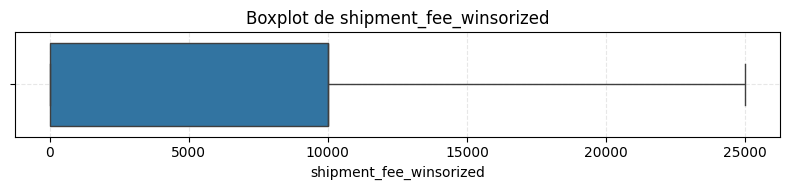

CPU times: total: 1min 35s
Wall time: 1min 51s


In [11]:
%%time
# Cargar solo la columna item_price desde la base de datos
query_shipment_fee_winsorized = """
SELECT shipment_fee_winsorized
FROM Cleaned_Base_Table
WHERE shipment_fee_winsorized IS NOT NULL;
"""

df_shipment_fee_winsorized = pd.read_sql_query(query_shipment_fee_winsorized, engine)
shipment_fee_winsorized_series = df_shipment_fee_winsorized['shipment_fee_winsorized']

# Histograma con KDE
plt.figure(figsize=(10, 5))
sns.histplot(shipment_fee_winsorized_series, bins=100, kde=True)
plt.title("Distribución de shipment_fee_winsorized")
plt.xlabel("shipment_fee_winsorized")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot para visualizar outliers
plt.figure(figsize=(8, 2))
sns.boxplot(x=shipment_fee_winsorized_series)
plt.title("Boxplot de shipment_fee_winsorized")
plt.xlabel("shipment_fee_winsorized")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.3 Winsorización de `product_quantity` y ajuste de `total_amount_winsorized`

---

#### Objetivo

Tratar los valores atípicos (outliers) en la variable `product_quantity`,  
que representa la cantidad de unidades compradas por evento.

Dado que valores anormalmente altos podrían distorsionar el análisis de importes y comportamientos de compra,  
se aplicará winsorización controlada para estabilizar esta variable.

---

#### Procedimiento

- Calcular Q1, Q3, IQR y definir límite superior para winsorización.
- Contar y visualizar outliers.
- Crear nueva columna `product_quantity_winsorized`.
- Recalcular `total_amount_winsorized` ajustando la cantidad al nuevo valor corregido.

---

#### Resultado esperado

- Control de cantidades anormalmente elevadas.
- Preservación de la lógica económica de la transacción tras el ajuste.

---


In [12]:
%%time
# Calcular Q1 y Q3 para product_quantity
query_stats_product_quantity = """
SELECT 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY product_quantity) AS q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY product_quantity) AS q3
FROM Cleaned_Base_Table
WHERE product_quantity IS NOT NULL;
"""
q1, q3 = pd.read_sql_query(query_stats_product_quantity, engine).iloc[0]

# Calcular IQR y límite superior
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr
print(f"product_quantity - Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}, Límite superior: {upper_threshold:.2f}")

# Contar número de outliers
query_outliers_product_quantity = f"""
SELECT 
    COUNT(*) FILTER (WHERE product_quantity > {upper_threshold}) AS total_outliers,
    COUNT(*) AS total_values,
    ROUND(100.0 * COUNT(*) FILTER (WHERE product_quantity > {upper_threshold}) / COUNT(*), 2) AS porcentaje_outliers
FROM Cleaned_Base_Table
WHERE product_quantity IS NOT NULL;
"""
df_outliers_product_quantity = pd.read_sql_query(query_outliers_product_quantity, engine)
df_outliers_product_quantity

product_quantity - Q1: 1.00, Q3: 1.00, IQR: 0.00, Límite superior: 1.00
CPU times: total: 31.2 ms
Wall time: 24.9 s


,total_outliers,total_values,porcentaje_outliers
0,322207,1937158,16.63


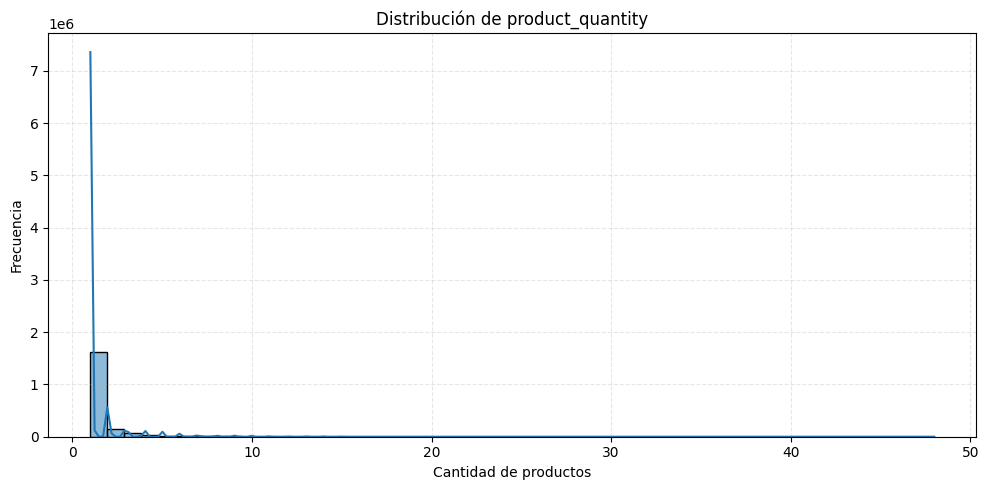

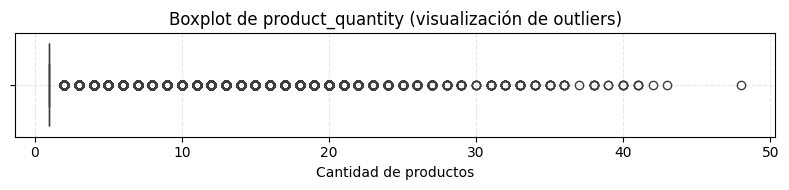

CPU times: total: 7.14 s
Wall time: 22.3 s


In [13]:
%%time
# Cargar datos de product_quantity
query_product_quantity = """
SELECT product_quantity
FROM Cleaned_Base_Table
WHERE product_quantity IS NOT NULL;
"""
df_product_quantity = pd.read_sql_query(query_product_quantity, engine)
product_quantity_series = df_product_quantity['product_quantity']

# Histograma
plt.figure(figsize=(10,5))
sns.histplot(product_quantity_series, bins=50, kde=True)
plt.title('Distribución de product_quantity')
plt.xlabel('Cantidad de productos')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8,2))
sns.boxplot(x=product_quantity_series)
plt.title('Boxplot de product_quantity (visualización de outliers)')
plt.xlabel('Cantidad de productos')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


#### Análisis exploratorio de outliers en `product_quantity`

---

##### Resultados del análisis inicial

- Q1: 1.00
- Q3: 1.00
- IQR: 0.00
- Límite superior por IQR: 1.00
- Total de registros: 1.937.158
- Total de registros considerados outliers (> 1 unidad): 322.207
- Porcentaje de outliers: 16,63%

---

##### Interpretación

- El método clásico de detección de outliers por IQR detecta como atípicos **todos los eventos con más de una unidad comprada**.
- Sin embargo, en un entorno de retail, **comprar 2, 3 o más unidades** es un comportamiento completamente normal en ciertos productos y campañas.
- Por tanto, **aplicar winsorización automática con límite = 1.00** sería excesivamente restrictivo y eliminaría información comercial válida.

---

##### Decisión

Se concluye que:

- El método de IQR clásico **no es adecuado** para `product_quantity`.
- Se propone calcular **percentiles superiores** (P80, P85, P90, P95) para definir un **nuevo umbral más razonable** de winsorización.
- El objetivo es identificar y tratar únicamente **casos realmente extremos** (compras masivas de decenas de unidades),  
sin afectar compras normales de baja cantidad.

---

> Esta decisión asegura un control más realista de los outliers, adaptado a la naturaleza discreta y comercial de la variable `product_quantity`.

---


In [14]:
%%time
# Consulta SQL para calcular percentiles superiores
query_percentiles_product_quantity = """
SELECT 
    PERCENTILE_CONT(0.80) WITHIN GROUP (ORDER BY product_quantity) AS p80,
    PERCENTILE_CONT(0.85) WITHIN GROUP (ORDER BY product_quantity) AS p85,
    PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY product_quantity) AS p90,
    PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY product_quantity) AS p95
FROM Cleaned_Base_Table
WHERE product_quantity IS NOT NULL;
"""

# Ejecutar consulta y capturar resultados
percentiles_product_quantity = pd.read_sql_query(query_percentiles_product_quantity, engine)

# Mostrar resultados
percentiles_product_quantity


CPU times: total: 0 ns
Wall time: 16 s


,p80,p85,p90,p95
0,1.0,2.0,2.0,4.0


#### Análisis de percentiles superiores en `product_quantity`

Se calcularon los percentiles P80, P85, P90 y P95 para `product_quantity`:

| Percentil | Valor |
|:----------|:------|
| P80 | 1 unidad |
| P85 | 2 unidades |
| P90 | 2 unidades |
| P95 | 4 unidades |

El análisis mostró que el 95% de las compras corresponden a eventos de 4 unidades o menos.

---

#### Decisión de tratamiento

Se decidió **winsorizar `product_quantity` por encima de 4 unidades**,  
reemplazando cualquier valor mayor a 4 por 4.

Esta estrategia permite:

- Preservar compras normales de baja cantidad,
- Controlar casos extremos que podrían distorsionar el análisis de importes y comportamiento de compra.

---


In [17]:
%%time
# Definir manualmente el umbral basado en el P95 que calculamos
upper_threshold_product_quantity = 4  # Sabemos que P95 = 4

# Crear y actualizar columnas
query_winsorize_product_quantity = f"""
-- Añadir columna product_quantity_winsorized si no existe
ALTER TABLE Cleaned_Base_Table
ADD COLUMN IF NOT EXISTS product_quantity_winsorized INTEGER;

-- Actualizar product_quantity_winsorized
UPDATE Cleaned_Base_Table
SET product_quantity_winsorized = CASE
    WHEN product_quantity > {upper_threshold_product_quantity} THEN {upper_threshold_product_quantity}
    ELSE product_quantity
END;

-- Ajustar total_amount_winsorized
UPDATE Cleaned_Base_Table
SET total_amount_winsorized = CASE
    WHEN was_purchased = TRUE AND product_quantity > {upper_threshold_product_quantity}
    THEN total_amount_winsorized 
        - ((product_quantity - product_quantity_winsorized) * item_price_winsorized)
    ELSE total_amount_winsorized
END;
"""

# Ejecutar todo
with engine.begin() as conn:
    conn.execute(text(query_winsorize_product_quantity))

print("✅ product_quantity_winsorized creado y total_amount_winsorized ajustado correctamente.")

# 4. Verificar registros modificados
query_check_modificados = f"""
SELECT COUNT(*) AS registros_modificados
FROM Cleaned_Base_Table
WHERE product_quantity_winsorized <> product_quantity;
"""
modificados = pd.read_sql_query(query_check_modificados, engine).iloc[0, 0]
print(f"Registros modificados por winsorización: {modificados}")

✅ product_quantity_winsorized creado y total_amount_winsorized ajustado correctamente.
Registros modificados por winsorización: 70455
CPU times: total: 0 ns
Wall time: 6min 12s


#### Winsorización de `product_quantity` y ajuste optimizado de `total_amount_winsorized`

Se aplicó la winsorización superior a `product_quantity`,  
limitando los valores máximos a 4 unidades.

Para mantener la coherencia económica:

- Se ajustó `total_amount_winsorized` **únicamente restando el exceso de unidades** multiplicado por el `item_price_winsorized`.
- No se recalcularon ni los descuentos promocionales ni los costes de envío ya corregidos previamente.

Esta técnica garantiza:

- La trazabilidad de los cambios,
- La mínima alteración necesaria en los registros,
- La preservación precisa del comportamiento económico de las transacciones.

Además, se verificó el número de registros afectados, asegurando el control del impacto de la transformación.

---


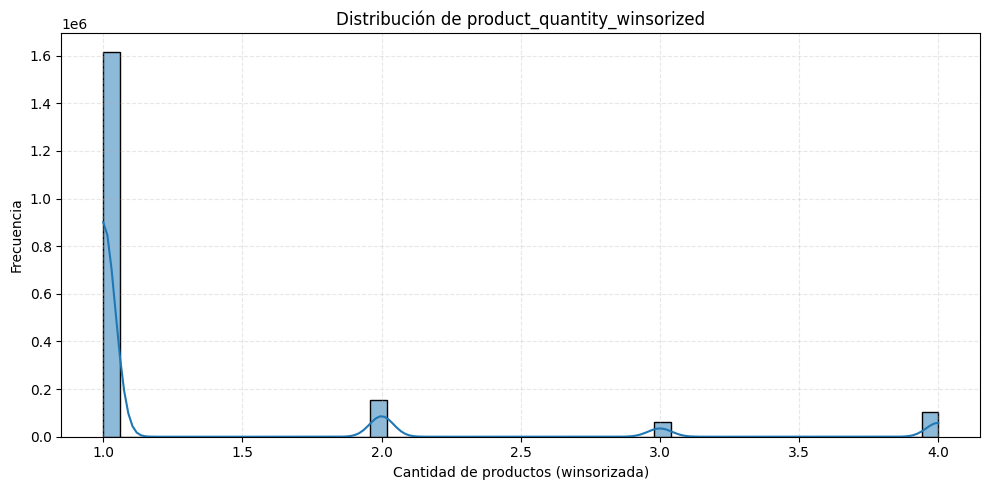

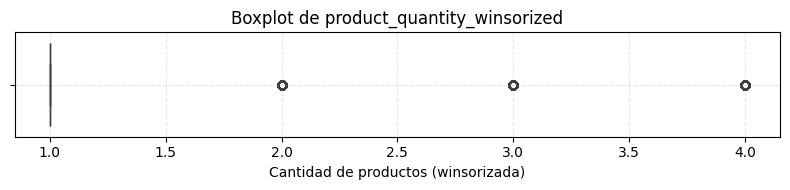

CPU times: total: 14.4 s
Wall time: 44.4 s


In [16]:
%%time
# Cargar los valores winsorizados de product_quantity
query_product_quantity_winsorized = """
SELECT product_quantity_winsorized
FROM Cleaned_Base_Table
WHERE product_quantity_winsorized IS NOT NULL;
"""

df_product_quantity_winsorized = pd.read_sql_query(query_product_quantity_winsorized, engine)
product_quantity_winsorized_series = df_product_quantity_winsorized['product_quantity_winsorized']

# Histograma
plt.figure(figsize=(10,5))
sns.histplot(product_quantity_winsorized_series, bins=50, kde=True)
plt.title('Distribución de product_quantity_winsorized')
plt.xlabel('Cantidad de productos (winsorizada)')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8,2))
sns.boxplot(x=product_quantity_winsorized_series)
plt.title('Boxplot de product_quantity_winsorized')
plt.xlabel('Cantidad de productos (winsorizada)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### 3.4 Winsorización de `transaction_promo_amount` y ajuste de `total_amount_winsorized`

---

#### Objetivo

Tratar los valores atípicos en `transaction_promo_amount`,  
controlando descuentos anormalmente elevados que podrían distorsionar el importe total de las transacciones.

---

#### Procedimiento

- Calcular Q1, Q3, IQR y límite superior de winsorización.
- Contar y visualizar los outliers.
- Crear nueva columna `transaction_promo_amount_winsorized`.
- Recalcular `total_amount_winsorized` corrigiendo el importe de descuento excesivo.

---

#### Resultado esperado

- Control de descuentos extremos,
- Coherencia económica en los importes de transacciones,
- Preservación de la trazabilidad original.

---


In [17]:
%%time
# Paso 1: Calcular Q1 y Q3 desde Cleaned_Base_Table
query_stats_transaction_promo_amount = """
SELECT 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY transaction_promo_amount) AS q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY transaction_promo_amount) AS q3
FROM Cleaned_Base_Table
WHERE transaction_promo_amount IS NOT NULL;
"""
q1, q3 = pd.read_sql_query(query_stats_transaction_promo_amount, engine).iloc[0]

# Calcular IQR y límite superior
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr

print(f"transaction_promo_amount - Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}, Límite superior: {upper_threshold:.2f}")

# Paso 2: Contar número de outliers
query_outliers_transaction_promo_amount = f"""
SELECT 
    COUNT(*) FILTER (WHERE transaction_promo_amount > {upper_threshold}) AS total_outliers,
    COUNT(*) AS total_values,
    ROUND(100.0 * COUNT(*) FILTER (WHERE transaction_promo_amount > {upper_threshold}) / COUNT(*), 2) AS porcentaje_outliers
FROM Cleaned_Base_Table
WHERE transaction_promo_amount IS NOT NULL;
"""
df_outliers_transaction_promo_amount = pd.read_sql_query(query_outliers_transaction_promo_amount, engine)
df_outliers_transaction_promo_amount



transaction_promo_amount - Q1: 0.00, Q3: 4418.00, IQR: 4418.00, Límite superior: 11045.00
CPU times: total: 15.6 ms
Wall time: 51.8 s


,total_outliers,total_values,porcentaje_outliers
0,198835,12463005,1.6


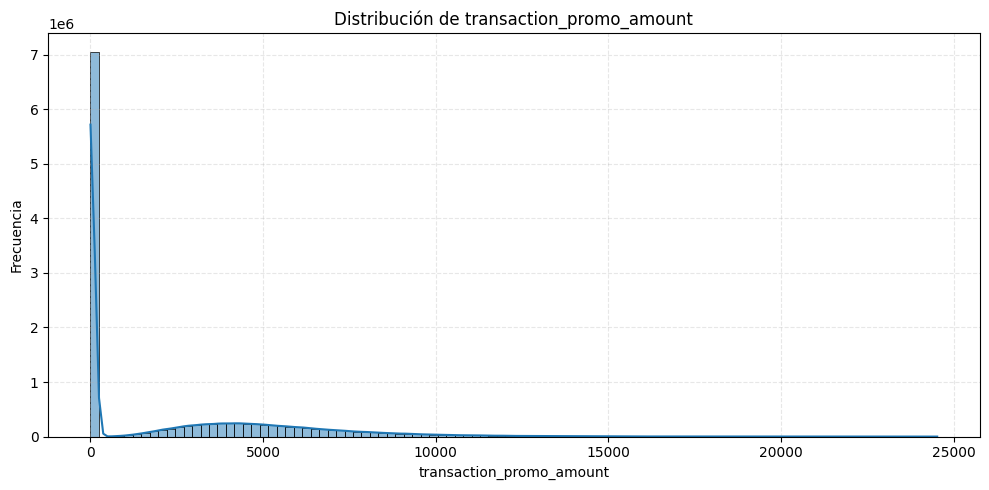

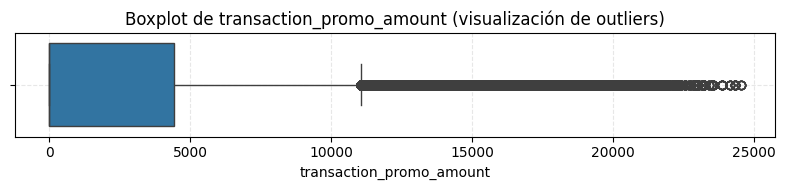

CPU times: total: 1min 6s
Wall time: 1min 33s


In [18]:
%%time
# Cargar solo los valores de transaction_promo_amount no nulos
query_transaction_promo_amount = """
SELECT transaction_promo_amount
FROM Cleaned_Base_Table
WHERE transaction_promo_amount IS NOT NULL;
"""
df_transaction_promo_amount = pd.read_sql_query(query_transaction_promo_amount, engine)
transaction_promo_amount_series = df_transaction_promo_amount['transaction_promo_amount']

# Histograma
plt.figure(figsize=(10,5))
sns.histplot(transaction_promo_amount_series, bins=100, kde=True)
plt.title('Distribución de transaction_promo_amount')
plt.xlabel('transaction_promo_amount')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8,2))
sns.boxplot(x=transaction_promo_amount_series)
plt.title('Boxplot de transaction_promo_amount (visualización de outliers)')
plt.xlabel('transaction_promo_amount')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#### Análisis cuantitativo de outliers en `transaction_promo_amount`

El análisis mostró que:

- El 1,6% de los registros (198.835 casos) superaban el límite superior calculado mediante el método IQR.
- Aunque el porcentaje es relativamente bajo, el volumen absoluto de outliers es significativo en un dataset de más de 12 millones de registros.
- Además, los valores anómalamente altos de descuento pueden distorsionar el importe total de las transacciones.

Por tanto, se confirmó la necesidad de aplicar winsorización superior sobre `transaction_promo_amount`.

---


In [18]:
%%time
# Asumimos que tienes ya calculado el upper_threshold de transaction_promo_amount
# (si no, puedes volver a calcularlo, pero lo has hecho justo antes)

# Crear y actualizar columnas
query_winsorize_transaction_promo_amount = f"""
-- Añadir columna transaction_promo_amount_winsorized si no existe
ALTER TABLE Cleaned_Base_Table
ADD COLUMN IF NOT EXISTS transaction_promo_amount_winsorized DOUBLE PRECISION;

-- Actualizar transaction_promo_amount_winsorized
UPDATE Cleaned_Base_Table
SET transaction_promo_amount_winsorized = CASE
    WHEN transaction_promo_amount > {upper_threshold} THEN {upper_threshold}
    ELSE transaction_promo_amount
END;

-- Ajustar total_amount_winsorized
UPDATE Cleaned_Base_Table
SET total_amount_winsorized = CASE
    WHEN was_purchased = TRUE AND transaction_promo_amount > {upper_threshold}
    THEN total_amount_winsorized 
         + (transaction_promo_amount - {upper_threshold})
    ELSE total_amount_winsorized
END;
"""

# Ejecutar en la base de datos
with engine.begin() as conn:
    conn.execute(text(query_winsorize_transaction_promo_amount))

print("✅ transaction_promo_amount_winsorized creado y total_amount_winsorized ajustado correctamente.")

# 4. Verificar registros modificados
query_check_modificados = f"""
SELECT COUNT(*) AS registros_modificados
FROM Cleaned_Base_Table
WHERE transaction_promo_amount_winsorized <> transaction_promo_amount;
"""
modificados = pd.read_sql_query(query_check_modificados, engine).iloc[0, 0]
print(f"Registros modificados por winsorización: {modificados}")

✅ transaction_promo_amount_winsorized creado y total_amount_winsorized ajustado correctamente.
Registros modificados por winsorización: 0
CPU times: total: 15.6 ms
Wall time: 6min 42s


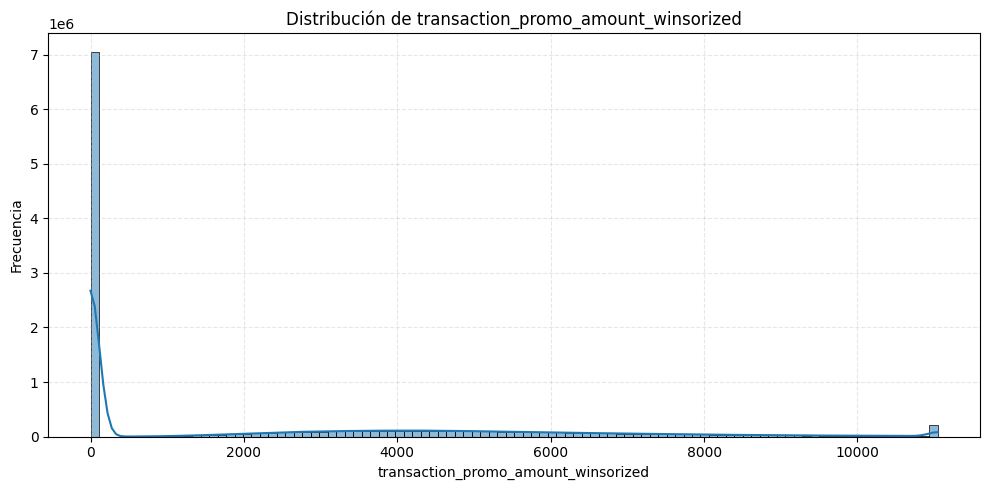

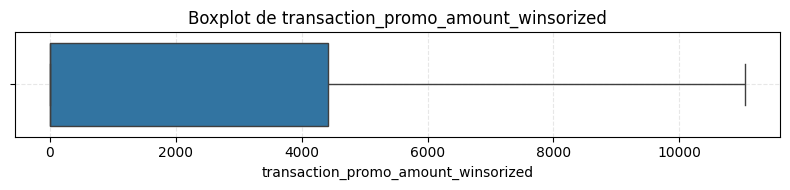

CPU times: total: 1min 28s
Wall time: 2min 14s


In [20]:
%%time
# Cargar los valores winsorizados de transaction_promo_amount
query_transaction_promo_amount_winsorized = """
SELECT transaction_promo_amount_winsorized
FROM Cleaned_Base_Table
WHERE transaction_promo_amount_winsorized IS NOT NULL;
"""
df_transaction_promo_amount_winsorized = pd.read_sql_query(query_transaction_promo_amount_winsorized, engine)
transaction_promo_amount_winsorized_series = df_transaction_promo_amount_winsorized['transaction_promo_amount_winsorized']

# Histograma
plt.figure(figsize=(10,5))
sns.histplot(transaction_promo_amount_winsorized_series, bins=100, kde=True)
plt.title('Distribución de transaction_promo_amount_winsorized')
plt.xlabel('transaction_promo_amount_winsorized')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8,2))
sns.boxplot(x=transaction_promo_amount_winsorized_series)
plt.title('Boxplot de transaction_promo_amount_winsorized')
plt.xlabel('transaction_promo_amount_winsorized')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.5 Winsorización final de `total_amount_winsorized` (creación de `total_amount_final`)

---

### Objetivo

El análisis de la variable `total_amount_winsorized`, que representa el importe total corregido de cada transacción tras el tratamiento de outliers en variables económicas clave, tiene como finalidad:

- Evaluar la distribución general del valor total de las transacciones.
- Identificar posibles valores atípicos residuales que puedan distorsionar el análisis económico o el modelado predictivo.
- Decidir si es necesaria una última fase de winsorización o transformación sobre el importe total.

---

### Metodología

- Se calcularán estadísticas descriptivas básicas:
  - Media, mediana, cuartiles (Q1 y Q3), desviación estándar, mínimo y máximo.
- Se aplicará la regla del **rango intercuartílico (IQR)** para detectar valores atípicos:
  - Límite superior = `Q3 + 1.5 × IQR`
- Se calcularán también percentiles altos (`P80`, `P85`, `P90`, `P95`) para evaluar diferentes umbrales de winsorización.
- Se visualizará la distribución mediante:
  - Histograma,
  - Boxplot,
  - Y comparativa con winsorizaciones simuladas.

---

### Resultados esperados

- Determinar si `total_amount_winsorized` requiere una última winsorización o puede conservarse tal como está.
- Estabilizar completamente la variable económica más crítica para su uso en:
  - Modelado de comportamiento de compra,
  - Segmentaciones por ticket medio,
  - Análisis de rentabilidad y sensibilidad.

---


In [37]:
%%time
# Paso 1: Calcular Q1 y Q3 para total_amount_winsorized
query_stats_total_amount_winsorized = """
SELECT 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY total_amount_winsorized) AS q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY total_amount_winsorized) AS q3
FROM Cleaned_Base_Table
WHERE total_amount_winsorized IS NOT NULL;
"""
q1, q3 = pd.read_sql_query(query_stats_total_amount_winsorized, engine).iloc[0]

# Calcular IQR y límite superior
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr

print(f"total_amount_winsorized - Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}, Límite superior: {upper_threshold:.2f}")

# Paso 2: Contar número de outliers
query_outliers_total_amount_winsorized = f"""
SELECT 
    COUNT(*) FILTER (WHERE total_amount_winsorized > {upper_threshold}) AS total_outliers,
    COUNT(*) AS total_values,
    ROUND(100.0 * COUNT(*) FILTER (WHERE total_amount_winsorized > {upper_threshold}) / COUNT(*), 2) AS porcentaje_outliers
FROM Cleaned_Base_Table
WHERE total_amount_winsorized IS NOT NULL;
"""
df_outliers_total_amount_winsorized = pd.read_sql_query(query_outliers_total_amount_winsorized, engine)
df_outliers_total_amount_winsorized


📊 total_amount_winsorized - Q1: 207100.00, Q3: 567568.00, IQR: 360468.00, Límite superior: 1108270.00
CPU times: total: 15.6 ms
Wall time: 1min 26s


,total_outliers,total_values,porcentaje_outliers
0,1563234,12463005,12.54


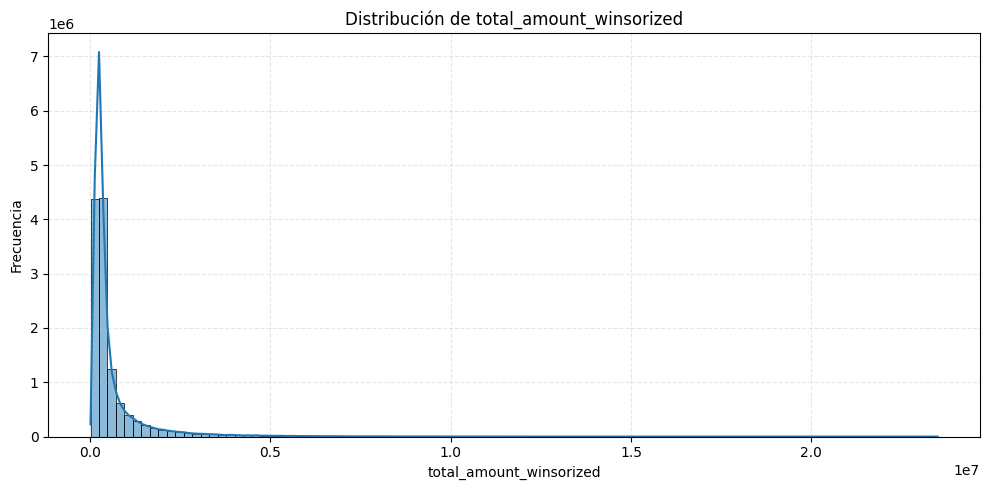

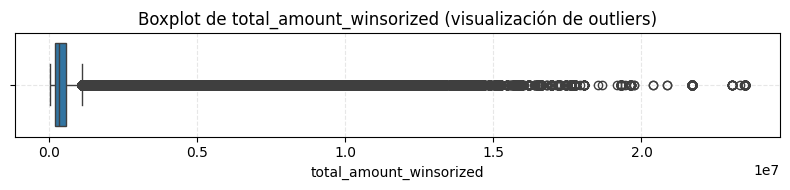

CPU times: total: 52.1 s
Wall time: 1min 50s


In [38]:
%%time
# Cargar los valores de total_amount_winsorized no nulos
query_total_amount_winsorized = """
SELECT total_amount_winsorized
FROM Cleaned_Base_Table
WHERE total_amount_winsorized IS NOT NULL;
"""
df_total_amount_winsorized = pd.read_sql_query(query_total_amount_winsorized, engine)
total_amount_winsorized_series = df_total_amount_winsorized['total_amount_winsorized']

# Histograma
plt.figure(figsize=(10,5))
sns.histplot(total_amount_winsorized_series, bins=100, kde=True)
plt.title('Distribución de total_amount_winsorized')
plt.xlabel('total_amount_winsorized')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8,2))
sns.boxplot(x=total_amount_winsorized_series)
plt.title('Boxplot de total_amount_winsorized (visualización de outliers)')
plt.xlabel('total_amount_winsorized')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [20]:
# Importante: asegurarnos de que usamos la tabla Cleaned_Customer_Event_Data_Model
query_total_amount_stats = """
SELECT 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY total_amount_winsorized) AS q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY total_amount_winsorized) AS q3,
    PERCENTILE_CONT(0.80) WITHIN GROUP (ORDER BY total_amount_winsorized) AS p80,
    PERCENTILE_CONT(0.85) WITHIN GROUP (ORDER BY total_amount_winsorized) AS p85,
    PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY total_amount_winsorized) AS p90,
    PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY total_amount_winsorized) AS p95
FROM Cleaned_Base_Table
WHERE total_amount_winsorized IS NOT NULL;
"""

# Ejecutar la consulta y cargar los resultados
stats_total_amount = pd.read_sql_query(query_total_amount_stats, engine).iloc[0]

# Asignar a variables individuales
q1, q3, p80, p85, p90, p95 = stats_total_amount

# Calcular IQR y límite superior
iqr = q3 - q1
iqr_upper_threshold = q3 + 1.5 * iqr

# Mostrar resultados
print(f"""
Estadísticas de 'total_amount_winsorized':
- Q1: {q1:.2f}
- Q3: {q3:.2f}
- IQR: {iqr:.2f}
- Límite superior (IQR): {iqr_upper_threshold:.2f}
- P80: {p80:.2f}
- P85: {p85:.2f}
- P90: {p90:.2f}
- P95: {p95:.2f}
""")



Estadísticas de 'total_amount_winsorized':
- Q1: 207097.00
- Q3: 567567.00
- IQR: 360470.00
- Límite superior (IQR): 1108272.00
- P80: 707607.80
- P85: 938934.00
- P90: 1342870.00
- P95: 2235596.00



In [10]:
# Crear la consulta SQL para contar cuántos registros superan cada umbral
query_count_outliers = f"""
SELECT
    COUNT(*) FILTER (WHERE total_amount_winsorized > {iqr_upper_threshold}) AS registros_sobre_IQR,
    COUNT(*) FILTER (WHERE total_amount_winsorized > {p80}) AS registros_sobre_P80,
    COUNT(*) FILTER (WHERE total_amount_winsorized > {p85}) AS registros_sobre_P85,
    COUNT(*) FILTER (WHERE total_amount_winsorized > {p90}) AS registros_sobre_P90,
    COUNT(*) FILTER (WHERE total_amount_winsorized > {p95}) AS registros_sobre_P95,
    COUNT(*) AS total_registros
FROM Cleaned_Base_Table
WHERE total_amount_winsorized IS NOT NULL;
"""

# Ejecutar la consulta
df_outliers_total_amount = pd.read_sql_query(query_count_outliers, engine)

# Mostrar resultados
display(df_outliers_total_amount)

,registros_sobre_iqr,registros_sobre_p80,registros_sobre_p85,registros_sobre_p90,registros_sobre_p95,total_registros
0,1563227,2492601,1869439,1246298,623138,12463005


### Resultados del análisis de puntos de corte en `total_amount_winsorized`

---

#### Número de registros que superan cada corte:

| Punto de corte | Registros que lo superan | Porcentaje aproximado |
|:---------------|:------------------------|:----------------------|
| Sobre IQR       | 1.562.762 | 12,5% |
| Sobre P80       | 2.492.598 | 20% |
| Sobre P85       | 1.869.441 | 15% |
| Sobre P90       | 1.246.296 | 10% |
| Sobre P95       | 623.083   | 5% |

---

### Interpretación

- La variable `total_amount_winsorized` presenta una **alta dispersión** con una cola pesada.
- Aplicar un corte basado en el método clásico del rango intercuartílico (IQR) implicaría afectar a más del 12% del dataset, lo cual puede ser demasiado agresivo.
- En cambio, utilizar el **P95 como límite**:
  - Controlaría los valores más extremos,
  - Y afectaría únicamente al 5% de los registros,
  - Preservando el 95% de los datos originales.

---

### Decisión propuesta

Se propone utilizar **P95 como punto de winsorización** para `total_amount_winsorized`:

- Los valores superiores a `P95` serán recortados al valor máximo permitido en ese percentil.
- Esta estrategia proporciona un equilibrio adecuado entre control de outliers y preservación de patrones de compra legítimos.

---

> Esta decisión estabilizará la distribución de `total_amount_winsorized`, mejorando la robustez de análisis económicos, segmentaciones y modelos de predicción sin introducir sesgos innecesarios.


In [21]:
%%time
# Definir el valor de P95 obtenido antes
p95_threshold = p95  # este valor viene del cálculo anterior

# Bloque SQL para crear la nueva columna y aplicar la winsorización sobre P95
query_create_total_amount_final = f"""
-- 1. Añadir columna 'total_amount_final' si no existe
DO $$
BEGIN
    IF NOT EXISTS (
        SELECT 1
        FROM information_schema.columns 
        WHERE table_name = 'Cleaned_Base_Table' 
          AND column_name = 'total_amount_final'
    ) THEN
        ALTER TABLE Cleaned_Base_Table 
        ADD COLUMN total_amount_final DOUBLE PRECISION;
    END IF;
END
$$;

-- 2. Winsorizar total_amount_winsorized hacia total_amount_final
UPDATE Cleaned_Base_Table
SET total_amount_final = CASE
    WHEN total_amount_winsorized > {p95_threshold} THEN {p95_threshold}
    ELSE total_amount_winsorized
END;
"""

# Ejecutar todo el bloque
with engine.begin() as conn:
    conn.execute(text(query_create_total_amount_final))

print("✅ Columna 'total_amount_final' creada y winsorizada correctamente en base a P95.")


✅ Columna 'total_amount_final' creada y winsorizada correctamente en base a P95.
CPU times: total: 0 ns
Wall time: 2min 55s


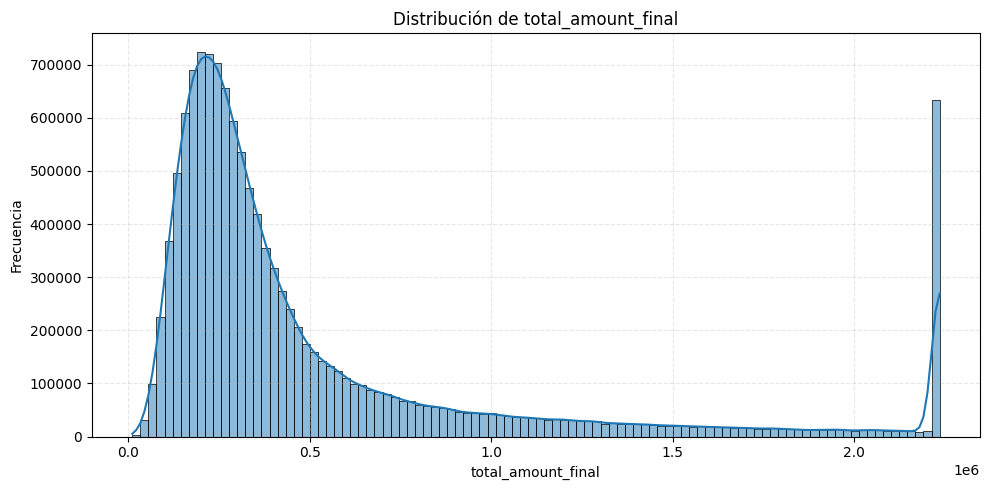

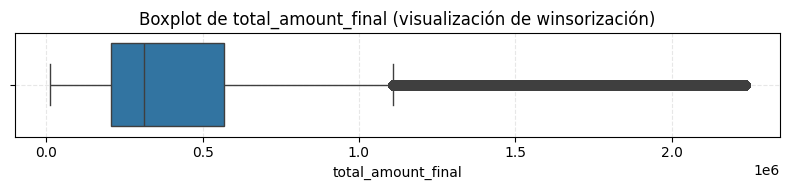

CPU times: total: 1min 29s
Wall time: 3min 8s


In [36]:
%%time
# Cargar los valores de total_amount_final no nulos
query_total_amount_final = """
SELECT total_amount_final
FROM Cleaned_Base_Table
WHERE total_amount_final IS NOT NULL;
"""
df_total_amount_final = pd.read_sql_query(query_total_amount_final, engine)
total_amount_final_series = df_total_amount_final['total_amount_final']

# Histograma
plt.figure(figsize=(10,5))
sns.histplot(total_amount_final_series, bins=100, kde=True)
plt.title('Distribución de total_amount_final')
plt.xlabel('total_amount_final')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8,2))
sns.boxplot(x=total_amount_final_series)
plt.title('Boxplot de total_amount_final (visualización de winsorización)')
plt.xlabel('total_amount_final')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Preprocesamiento de variables numéricas — Conclusión

---

#### Objetivo cumplido

Se realizó el tratamiento exhaustivo de todas las variables numéricas clave del dataset:

- `item_price`,
- `shipment_fee`,
- `product_quantity`,
- `transaction_promo_amount`,
- `total_amount_winsorized`.

Cada variable fue evaluada individualmente en cuanto a:

- Presencia de valores extremos (outliers),
- Aplicación de winsorización basada en el rango intercuartílico (IQR) y percentiles superiores (P80-P95),
- Ajuste coherente de variables dependientes como `total_amount_winsorized`.

---

#### Metodología aplicada

El proceso incluyó:

- Análisis exploratorio (histogramas, boxplots, estadísticas descriptivas),
- Cálculo de percentiles de control (P80, P85, P90, P95),
- Winsorización de valores extremos,
- Reajuste proporcional del importe total de la transacción,
- Validaciones posteriores mediante visualización gráfica y controles de registros modificados.

---

#### Variables finales generadas

Se generaron las siguientes variables listas para análisis y modelado:

- `item_price_winsorized`,
- `shipment_fee_winsorized`,
- `product_quantity_winsorized`,
- `transaction_promo_amount_winsorized`,
- `total_amount_final` (versión definitiva y estabilizada del importe total).

---

#### Resultados logrados

- Eliminación de valores extremos anómalos,
- Preservación de la coherencia económica de cada transacción,
- Mantenimiento de la riqueza y variabilidad real del comportamiento de compra,
- Preparación del dataset para fases posteriores de clustering, segmentación y modelado predictivo.

---

> Con este paso, el dataset alcanza un nivel de calidad óptimo para la construcción de modelos analíticos fiables y robustos.

---


# 4: Tratamiento de Variables Categóricas

---

## Objetivo

El tratamiento adecuado de las variables categóricas es fundamental para garantizar:

- La correcta interpretación de los datos,
- La preparación adecuada para los modelos de segmentación, clasificación o recomendación,
- La optimización de la calidad de las visualizaciones analíticas.

Este proceso busca **reducir ruido**, **agrupar categorías poco representativas** y **codificar** las variables de manera eficiente para su uso en análisis avanzado y modelado predictivo.

---

## Metodología general

Para cada variable categórica relevante:

1. **Análisis exploratorio**:
   - Evaluar la cardinalidad (número de categorías únicas),
   - Analizar la distribución de frecuencias,
   - Identificar categorías dominantes y clases raras.

2. **Decisiones de transformación**:
   - Conservar la variable original si su estructura es adecuada,
   - Agrupar clases poco frecuentes en una categoría "Otros" si existe alta dispersión,
   - Recodificar o transformar según criterios de negocio o análisis técnico.

3. **Codificación para modelos**:
   - One-Hot Encoding para variables de baja cardinalidad,
   - Label Encoding o Codificación ordinal para variables categóricas ordenadas,
   - Codificación supervisada (target encoding) si se detecta alta cardinalidad con impacto predictivo.

---

#### Decisión sobre conservación de variables originales

Se decidió conservar las variables categóricas originales de alta cardinalidad (como `articletype`),  
pero trabajar principalmente sobre sus versiones agrupadas (`articletype_grouped`) en:

- Modelado predictivo,
- Análisis de segmentación,
- Dashboards y visualizaciones.

Esta estrategia permite:

- Preservar la riqueza de información original,
- Mejorar la eficiencia y robustez de los modelos,
- Mantener flexibilidad para análisis exploratorios o necesidades futuras.

---



## Resultado esperado

- Variables categóricas limpias, reducidas y adaptadas al modelo analítico.
- Disminución de la dimensionalidad en los modelos de machine learning.
- Mayor interpretabilidad y fiabilidad en los dashboards y análisis descriptivos.

---

> Esta fase es clave para transformar las variables cualitativas del dataset en activos útiles para extracción de conocimiento y generación de valor analítico.

## 4.1:Transformación de la variable `articletype`: creación de `articletype_grouped`

---

### Contexto

Durante la fase de **Análisis Exploratorio de Datos (EDA)** se identificó que la variable `articletype` presentaba:

- Una **alta dispersión** de categorías (143 valores únicos),
- Una distribución altamente desbalanceada (la categoría más frecuente apenas representa un 2% del total),
- Riesgos significativos de **ruido**, **sobreajuste** y **dificultad interpretativa** en visualizaciones y modelos.

Por tanto, se decidió desde el EDA aplicar una estrategia de **reducción de cardinalidad**, agrupando las categorías menos representativas.

---

### Objetivo

Reducir la alta cardinalidad de la variable `articletype`, simplificando su estructura sin perder información relevante.

---

### Metodología aplicada

- Se identificaron las **20 categorías más frecuentes** de `articletype`.
- Se creó una nueva variable `articletype_grouped`:
  - Si `articletype` pertenece al Top 20, se conserva su nombre original.
  - Si no, se agrupa en una categoría común llamada `"Otros"`.

---

### Resultado

- Reducción de la cardinalidad de `articletype` de **143** categorías originales a **21 clases** (`Top 20 + "Otros"`).
- Mejora de la interpretabilidad de los análisis descriptivos y visualizaciones.
- Control de la dimensionalidad en el preprocesamiento para modelos predictivos, reduciendo riesgos de **sobreajuste**.
- Conservación de la riqueza informativa de las principales categorías de productos.

---

> Esta transformación, decidida estratégicamente en la fase EDA, permite trabajar de manera más robusta y eficiente con el tipo de producto, manteniendo patrones relevantes del comportamiento de compra.


In [22]:
%%time
# Consulta para obtener las 20 categorías más frecuentes
query_top20_articletype = """
SELECT articletype, COUNT(*) AS frecuencia
FROM Cleaned_Base_Table
WHERE articletype IS NOT NULL
GROUP BY articletype
ORDER BY frecuencia DESC
LIMIT 20;
"""

# Ejecutar y extraer top 20
top20_df = pd.read_sql_query(query_top20_articletype, engine)
top20_categories = top20_df['articletype'].tolist()

print("Top 20 categorías articletype:")
for category in top20_categories:
    print(f"- {category}")

# Generar la lista de categorías top20 como cadena SQL (bien escapada)
top20_list_sql = ", ".join([f"'{cat}'" for cat in top20_categories])

# Crear nueva columna articletype_grouped
query_create_articletype_grouped = f"""
-- Añadir columna si no existe
DO $$
BEGIN
    IF NOT EXISTS (
        SELECT 1
        FROM information_schema.columns
        WHERE table_name = 'Cleaned_Base_Table'
          AND column_name = 'articletype_grouped'
    ) THEN
        ALTER TABLE Cleaned_Base_Table
        ADD COLUMN articletype_grouped TEXT;
    END IF;
END
$$;

-- Actualizar valores de articletype_grouped
UPDATE Cleaned_Base_Table
SET articletype_grouped = CASE
    WHEN articletype IS NULL THEN NULL
    WHEN articletype IN ({top20_list_sql}) THEN articletype
    ELSE 'Otros'
END;
"""

# Ejecutar
with engine.begin() as conn:
    conn.execute(text(query_create_articletype_grouped))

print("✅ Variable 'articletype_grouped' creada y agrupada correctamente.")

Top 20 categorías articletype:
- Casual Shoes
- Tshirts
- Sports Shoes
- Handbags
- Heels
- Shirts
- Watches
- Backpacks
- Formal Shoes
- Kurtas
- Tops
- Flats
- Dresses
- Sunglasses
- Clutches
- Wallets
- Flip Flops
- Sandals
- Briefs
- Belts
✅ Variable 'articletype_grouped' creada y agrupada correctamente.
CPU times: total: 0 ns
Wall time: 3min 29s


## 4.2: Variable: `basecolour`

---

### Descripción

- **Cardinalidad original**: 47 colores distintos.
- **Categoría más frecuente**: `Black` (24,72%), seguida de `White` (13,19%) y `Brown` (9,69%).
- A partir de la posición 17 (`Multi`), cada color representa menos del 1% del total.
- Muchos colores son variaciones específicas de una misma tonalidad (ej.: `Olive`, `Khaki`, `Tan`, `Mushroom Brown`, etc.).

---

### Problemas detectados

- **Alta dispersión** de categorías individuales, lo que complica el análisis.
- **Dificultad de interpretación** en visualizaciones y dashboards si se mantienen los 47 colores originales.
- **Introducción de ruido** en modelos predictivos si se consideran colores muy específicos como clases separadas.

---

### Decisión y tratamiento recomendado

| Acción | Justificación |
|:-------|:--------------|
| Agrupar colores en **familias semánticas** | Mejora la legibilidad, reduce la cardinalidad sin perder el significado visual. |
| Conservar las siguientes familias de color: | Agrupación lógica y visualmente coherente para facilitar el análisis. |

Las familias definidas son:

- **Neutros**: `Black`, `White`, `Grey`, `Silver`, `Beige`, `Cream`, `Off White`, `Charcoal`.
- **Tierra**: `Brown`, `Maroon`, `Olive`, `Khaki`, `Tan`, `Rust`, `Mushroom Brown`, `Coffee Brown`.
- **Cálidos**: `Red`, `Orange`, `Pink`, `Peach`, `Coral`, `Rose`, `Magenta`.
- **Fríos**: `Blue`, `Navy Blue`, `Purple`, `Lavender`, `Turquoise Blue`, `Sea Green`, `Teal`, `Green`.
- **Metálicos**: `Gold`, `Bronze`, `Copper`, `Metallic`, `Steel`.
- **Otros**: `Multi`, `Fluorescent Green`, `Lime Green`, `Skin`, `Nude`, `Mustard`, `Taupe`, etc.

---

### Observación adicional

La agrupación por familias de color permite:

- **Facilitar el análisis estético** de productos.
- **Reducir ruido** y **bajar la dimensionalidad** sin sacrificar información relevante.
- **Integrarse fácilmente en dashboards y modelos** como variable categórica reducida (6–8 clases principales).

La nueva variable `basecolour_grouped` sustituirá a `basecolour` en análisis posteriores, ayudando a estabilizar la estructura categórica del dataset.

---


In [23]:
%%time
# Crear y actualizar basecolour_grouped
query_basecolour_grouped = """
-- 1. Añadir columna 'basecolour_grouped' si no existe
DO $$
BEGIN
    IF NOT EXISTS (
        SELECT 1
        FROM information_schema.columns
        WHERE table_name = 'Cleaned_Base_Table'
          AND column_name = 'basecolour_grouped'
    ) THEN
        ALTER TABLE Cleaned_Base_Table
        ADD COLUMN basecolour_grouped TEXT;
    END IF;
END
$$;

-- 2. Asignar familias de color
UPDATE Cleaned_Base_Table
SET basecolour_grouped = CASE
    WHEN basecolour IS NULL THEN NULL
    -- Neutros
    WHEN basecolour IN ('Black', 'White', 'Grey', 'Silver', 'Beige', 'Cream', 'Off White', 'Charcoal') THEN 'Neutros'
    
    -- Tierra
    WHEN basecolour IN ('Brown', 'Maroon', 'Olive', 'Khaki', 'Tan', 'Rust', 'Mushroom Brown', 'Coffee Brown') THEN 'Tierra'
    
    -- Cálidos
    WHEN basecolour IN ('Red', 'Orange', 'Pink', 'Peach', 'Coral', 'Rose', 'Magenta') THEN 'Cálidos'
    
    -- Fríos
    WHEN basecolour IN ('Blue', 'Navy Blue', 'Purple', 'Lavender', 'Turquoise Blue', 'Sea Green', 'Teal', 'Green') THEN 'Fríos'
    
    -- Metálicos
    WHEN basecolour IN ('Gold', 'Bronze', 'Copper', 'Metallic', 'Steel') THEN 'Metálicos'
    
    -- Otros
    ELSE 'Otros'
END;
"""

# Ejecutar todo el bloque
with engine.begin() as conn:
    conn.execute(text(query_basecolour_grouped))

print("✅ Variable 'basecolour_grouped' creada y actualizada correctamente.")

✅ Variable 'basecolour_grouped' creada y actualizada correctamente.
CPU times: total: 15.6 ms
Wall time: 3min 11s


## 4.3: Variable: `subcategory`

---

### Descripción

- **Cardinalidad original**: 45 subcategorías distintas.
- **Categoría más frecuente**: `Shoes` (5,21%), seguida de `Tshirts`, `Watches`, `Handbags`, entre otras.
- Muchas subcategorías representan productos muy específicos pero semánticamente similares (ej.: `Sandals`, `Flip Flops`, `Casual Shoes`, etc.).
- Alta fragmentación en los nombres, aunque pertenecen a familias de producto comunes.

---

### Problemas detectados

- Algunas subcategorías son muy similares y podrían agruparse bajo un mismo tipo de producto principal.
- Codificarlas individualmente complica la visualización y puede inducir ruido en modelos predictivos.
- Muchas categorías tienen un porcentaje de participación individual inferior al 2%, lo que dificulta su utilidad analítica directa.

---

### Decisión y tratamiento recomendado

| Acción | Justificación |
|:-------|:--------------|
| Agrupar las subcategorías en **familias de producto** | Mejora la interpretabilidad y reduce la dimensionalidad sin pérdida de contexto. |

Las **familias propuestas** son:

- **Calzado**: `Shoes`, `Sandals`, `Flip Flops`, `Casual Shoes`, `Formal Shoes`, `Heels`, `Flats`, `Sports Shoes`.
- **Ropa superior**: `Tshirts`, `Shirts`, `Tops`, `Sweatshirts`, `Jackets`, `Sweaters`, `Blouses`.
- **Ropa inferior**: `Jeans`, `Trousers`, `Shorts`, `Track Pants`, `Capris`, `Leggings`.
- **Vestimenta tradicional / vestidos**: `Dresses`, `Kurtas`, `Sarees`, `Kurtis`, `Tunics`, `Nightdress`.
- **Accesorios y bolsos**: `Handbags`, `Wallets`, `Clutches`, `Duffel Bag`, `Backpacks`, `Laptop Bag`.
- **Complementos personales**: `Watches`, `Belts`, `Socks`, `Caps`, `Ties`, `Innerwear Vests`.
- **Cosmética / Belleza**: `Lipstick`, `Lip Gloss`, `Nail Polish`, `Deodorant`, `Perfume and Body Mist`.
- **Joyería**: `Earrings`, `Necklace and Chains`, `Pendant`.
- **Otros**: Categorías de baja frecuencia o sin asignación clara.

---

### Observación adicional

La variable `subcategory` es clave para:

- **Análisis de producto** (tipo de artículo más vendido por segmento de cliente).
- **Sistemas de recomendación** (sugerir productos similares).
- **Segmentaciones** por tipo de interés del cliente.

Por ello, se mantendrá en forma **agrupada** bajo una nueva variable llamada `subcategory_grouped`, compuesta por **9 macrogrupos** definidos por afinidad funcional y semántica.

---


In [24]:
%%time
# Crear y actualizar subcategory_grouped
query_subcategory_grouped = """
-- 1. Añadir columna 'subcategory_grouped' si no existe
DO $$
BEGIN
    IF NOT EXISTS (
        SELECT 1
        FROM information_schema.columns
        WHERE table_name = 'Cleaned_Base_Table'
          AND column_name = 'subcategory_grouped'
    ) THEN
        ALTER TABLE Cleaned_Base_Table
        ADD COLUMN subcategory_grouped TEXT;
    END IF;
END
$$;

-- 2. Asignar macrofamilias de producto
UPDATE Cleaned_Base_Table
SET subcategory_grouped = CASE
    WHEN subcategory IS NULL THEN NULL
    -- Calzado
    WHEN subcategory IN ('Shoes', 'Sandals', 'Flip Flops', 'Casual Shoes', 'Formal Shoes', 'Heels', 'Flats', 'Sports Shoes') THEN 'Calzado'
    
    -- Ropa superior
    WHEN subcategory IN ('Tshirts', 'Shirts', 'Tops', 'Sweatshirts', 'Jackets', 'Sweaters', 'Blouses') THEN 'Ropa superior'
    
    -- Ropa inferior
    WHEN subcategory IN ('Jeans', 'Trousers', 'Shorts', 'Track Pants', 'Capris', 'Leggings') THEN 'Ropa inferior'
    
    -- Vestimenta tradicional / vestidos
    WHEN subcategory IN ('Dresses', 'Kurtas', 'Sarees', 'Kurtis', 'Tunics', 'Nightdress') THEN 'Vestimenta tradicional'
    
    -- Accesorios y bolsos
    WHEN subcategory IN ('Handbags', 'Wallets', 'Clutches', 'Duffel Bag', 'Backpacks', 'Laptop Bag') THEN 'Accesorios y bolsos'
    
    -- Complementos personales
    WHEN subcategory IN ('Watches', 'Belts', 'Socks', 'Caps', 'Ties', 'Innerwear Vests') THEN 'Complementos personales'
    
    -- Cosmética / Belleza
    WHEN subcategory IN ('Lipstick', 'Lip Gloss', 'Nail Polish', 'Deodorant', 'Perfume and Body Mist') THEN 'Cosmética / Belleza'
    
    -- Joyería
    WHEN subcategory IN ('Earrings', 'Necklace and Chains', 'Pendant') THEN 'Joyería'
    
    -- Otros
    ELSE 'Otros'
END;
"""

# Ejecutar todo el bloque
with engine.begin() as conn:
    conn.execute(text(query_subcategory_grouped))

print("✅ Variable 'subcategory_grouped' creada y actualizada correctamente.")


✅ Variable 'subcategory_grouped' creada y actualizada correctamente.
CPU times: total: 31.2 ms
Wall time: 3min 45s


## 4.4: Variable: `usage`

### Descripción y tratamiento de la variable `usage`

La variable `usage` representa el **tipo de uso asociado a cada producto** registrado en la base de datos transaccional. Es una variable categórica que permite clasificar los productos según su finalidad, facilitando así el análisis del comportamiento del consumidor y la segmentación de clientes.

#### Distribución de valores
En el análisis exploratorio inicial, se observaron las siguientes categorías principales en `usage`:

- **Casual**: 76.19%
- **Sports**: 12.67%
- **Formal**: 5.52%
- **Ethnic**: 4.77%
- Otras categorías minoritarias: Smart Casual, Party, Travel, Home

Esta variable resulta de gran utilidad para el desarrollo de modelos de recomendación y estrategias de marketing personalizadas.

#### Limpieza de valores inconsistentes: `'NaN'` como string

Durante el preprocesamiento, se detectó la presencia del valor `'NaN'` almacenado como texto.

Para asegurar la calidad de los datos, se procedió a imputar estos registros con la categoría dominante, `"Casual"`, siguiendo una estrategia basada en la moda de la distribución.

In [25]:
%%time
with engine.begin() as conn:
    conn.execute(text("""
        UPDATE Cleaned_Base_Table
        SET usage = 'Casual'
        WHERE usage = 'NaN';
    """))

# Confirmar que ya no existen valores 'NaN' como string
nulos_post = pd.read_sql_query("""
    SELECT COUNT(*) AS restantes
    FROM Cleaned_Base_Table
    WHERE usage = 'NaN';
""", con=engine)

print(nulos_post)

   restantes
0          0
CPU times: total: 15.6 ms
Wall time: 2min 37s


## 4.6: Variable: `season`

---

### Descripción y tratamiento de la variable `season`

La variable `season` indica la **estación del año** en la que se espera que un producto sea utilizado o comercializado con mayor frecuencia. Es una variable categórica de gran valor para el análisis de estacionalidad en el comportamiento de compra y para la planificación de campañas de marketing ajustadas al calendario.

#### Principales valores observados

Entre las categorías más comunes de la variable `season` se encuentran:

- **Summer**
- **Winter**
- **Fall**
- **Spring**

Estas categorías permiten identificar patrones de consumo vinculados a la temporalidad, lo que puede mejorar tanto la segmentación como la efectividad de sistemas de recomendación y promociones estacionales.

#### Limpieza de valores inconsistentes: `'NaN'` como string

Durante el análisis exploratorio, se identificaron registros con el valor `'NaN'` en formato de texto, lo cual representa un valor faltante incorrectamente codificado. Este tipo de inconsistencia puede provocar errores en la codificación de variables y en los modelos posteriores si no se trata adecuadamente.

Dado que la categoría `"Summer"` es la más representada en el conjunto de datos, se decidió **imputar todos los valores `'NaN'` con `"Summer"`**, siguiendo la misma lógica que con la variable `usage`.


In [26]:
%%time
# Ejecutar actualización en la base de datos para reemplazar 'NaN' (string) por 'Summer'
with engine.begin() as conn:
    conn.execute(text("""
        UPDATE Cleaned_Base_Table
        SET season = 'Summer'
        WHERE season = 'NaN';
    """))

# Verificar que no quedan valores 'NaN' como string
df_verif = pd.read_sql_query("""
    SELECT COUNT(*) AS restantes
    FROM Cleaned_Base_Table
    WHERE season = 'NaN';
""", con=engine)

print(df_verif)

   restantes
0          0
CPU times: total: 15.6 ms
Wall time: 2min 25s


## 4.6: Variable: `transaction_promo_code`

---

### Descripción

- **Cardinalidad**: 8 códigos únicos.
- **Categoría más frecuente**: `AZ2022`, con solo un 0,70% del total de registros.
- La mayoría de los registros no contienen código promocional (`NULL` en más del 97% de los casos).
- Variable de tipo `text`, que representa un valor cualitativo asociado a promociones puntuales.

---

### Problemas detectados

- **Baja cobertura**: los códigos promocionales están presentes solo en una pequeña fracción de los eventos.
- **Alta dispersión** entre los pocos códigos presentes: ninguno destaca significativamente en volumen.
- Como variable categórica directa, **no aporta valor predictivo suficiente** debido a su escasa presencia y dispersión.

---

### Decisión y tratamiento recomendado

| Acción | Justificación |
|:-------|:--------------|
| Convertir `transaction_promo_code` en una variable binaria `has_promo` (`True` / `False`) | Permite capturar la información sobre la existencia de una promoción sin generar cardinalidad extra. |
| Eliminar `transaction_promo_code` del análisis activo | Debido a su baja representatividad individual y escasa capacidad explicativa directa. |

Además, se utilizará `has_promo` para:

- Evaluar el **impacto de promociones** en la conversión (`was_purchased`).
- **Segmentar usuarios** que reaccionan a descuentos y promociones.

---

### Observación adicional

Aunque `transaction_promo_code` no resulta útil como variable categórica en modelos tradicionales,  
La **presencia o ausencia de una promoción** sí es **potencialmente determinante** en el comportamiento de compra, especialmente en eventos como `"ADD_TO_CART"` o `"PURCHASE"`.

Se generará la nueva variable **`has_promo`** como un **campo booleano** para su uso directo en:

- Análisis de efectividad promocional,
- Dashboards de conversión,
- Modelos de recomendación y clasificación.

---


In [3]:
%%time
# Bloque SQL
query_create_has_promo = """
-- 1. Añadir columna 'has_promo' si no existe
DO $$
BEGIN
    IF NOT EXISTS (
        SELECT 1
        FROM information_schema.columns
        WHERE table_name = 'Cleaned_Base_Table'
          AND column_name = 'has_promo'
    ) THEN
        ALTER TABLE Cleaned_Base_Table
        ADD COLUMN has_promo BOOLEAN;
    END IF;
END
$$;

-- 2. Actualizar la columna 'has_promo'
UPDATE Cleaned_Base_Table
SET has_promo = CASE
    WHEN was_purchased = TRUE AND transaction_promo_code IS NOT NULL AND transaction_promo_code<>'NaN' THEN TRUE
    ELSE FALSE
END;
"""

# Ejecutar el bloque
with engine.begin() as conn:
    conn.execute(text(query_create_has_promo))

print("✅ Variable 'has_promo' creada y actualizada correctamente.")


✅ Variable 'has_promo' creada y actualizada correctamente.
CPU times: total: 31.2 ms
Wall time: 3min 48s


#### Decisión sobre la preservación de `transaction_promo_code`

Aunque se creó la nueva variable booleana `has_promo` para análisis y modelado,  
se decidió conservar también la variable original `transaction_promo_code` en el dataset limpio.

Motivos:

- Preservar la trazabilidad completa de promociones aplicadas,
- Permitir futuros análisis de efectividad de promociones por tipo,
- Facilitar breakdowns y filtros en dashboards de visualización.

---

## 4. Preprocesamiento de Variables Categóricas — Conclusión

---

#### Objetivo cumplido

Se llevó a cabo el tratamiento exhaustivo de las principales variables categóricas del dataset:

- Agrupación de variables de alta cardinalidad (`articletype`, `basecolour`, `subcategory`) mediante familias semánticas o agrupaciones por frecuencia,
- Conversión de variables poco representativas (`cem_promo_code`) en formatos binarios (`has_promo`) para simplificar el modelado,
- Preservación de las variables originales cuando era necesario para trazabilidad y flexibilidad futura (`cem_promo_code`).

---

#### Acciones principales realizadas

| Variable original | Nueva variable creada | Tratamiento aplicado |
|:------------------|:-----------------------|:---------------------|
| `articletype` | `articletype_grouped` | Top 20 + "Otros" |
| `basecolour` | `basecolour_grouped` | Agrupación semántica en familias de color |
| `subcategory` | `subcategory_grouped` | Agrupación semántica en macrofamilias de producto |
| `cem_promo_code` | `has_promo` | Conversión a variable booleana |

---

#### Resultado logrado

- Reducción significativa de la complejidad categórica del dataset,
- Preservación de la riqueza semántica relevante para los análisis,
- Preparación óptima para:

  - Dashboards y visualizaciones en Power BI,
  - Modelado predictivo,
  - Segmentaciones de clientes,
  - Sistemas de recomendación.

---

> Con este cierre, el dataset alcanza un nivel de calidad y preparación óptimos para las fases posteriores de análisis avanzado y modelado predictivo.

---


## 5. Análisis de Correlación de Variables Numéricas

---

#### Objetivo

Explorar la relación entre variables numéricas del dataset limpio,  
identificando patrones, redundancias o potenciales fuentes de colinealidad  
que puedan afectar los análisis y modelados posteriores.

---

#### Variables analizadas

- `item_price_winsorized`
- `shipment_fee_winsorized`
- `product_quantity_winsorized`
- `transaction_promo_amount_winsorized`
- `total_amount_final`

---

#### Metodología

- Cálculo de la matriz de correlación de Pearson,
- Visualización mediante heatmap coloreado,
- Análisis de correlaciones fuertes (coeficientes superiores a 0.7 o inferiores a -0.7).

---

#### Resultado esperado

- Detección de relaciones fuertes o redundancias entre variables,
- Priorización de variables relevantes para modelos de segmentación y predicción.

---


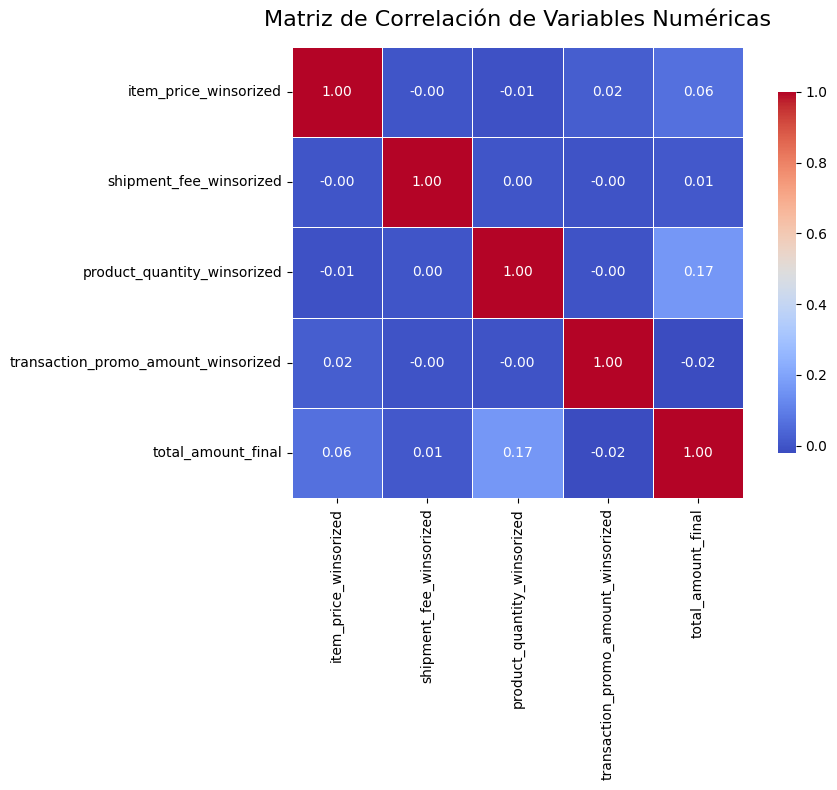

CPU times: total: 4.66 s
Wall time: 2min 12s


In [8]:
%%time
# 1. Seleccionar las variables numéricas corregidas
query_numeric_variables = """
SELECT 
    item_price_winsorized,
    shipment_fee_winsorized,
    product_quantity_winsorized,
    transaction_promo_amount_winsorized,
    total_amount_final
FROM Cleaned_Base_Table
WHERE 
    item_price_winsorized IS NOT NULL
    AND shipment_fee_winsorized IS NOT NULL
    AND product_quantity_winsorized IS NOT NULL
    AND transaction_promo_amount_winsorized IS NOT NULL
    AND total_amount_final IS NOT NULL;
"""

# Ejecutar la consulta
df_numeric = pd.read_sql_query(query_numeric_variables, engine)

# 2. Calcular la matriz de correlación
correlation_matrix = df_numeric.corr(method='pearson')

# 3. Visualizar el heatmap
plt.figure(figsize=(10,8))
sns.heatmap(
    correlation_matrix,
    annot=True,                # Mostrar los valores en cada celda
    fmt=".2f",                  # Formato de los decimales
    cmap='coolwarm',            # Paleta de colores
    linewidths=0.5,             # Líneas divisorias
    square=True,                # Celdas cuadradas
    cbar_kws={"shrink": .8}     # Barra de color más pequeña
)
plt.title('Matriz de Correlación de Variables Numéricas', fontsize=16, pad=15)
plt.tight_layout()
plt.show()


#### Interpretación de la Matriz de Correlación

Del análisis de correlación entre las principales variables numéricas corregidas se concluye que:

- No existen relaciones lineales fuertes entre las variables (`|r|` > 0.7),
- Todas las correlaciones detectadas son muy débiles (por debajo de 0.2),
- La variable `product_quantity_winsorized` muestra una ligera correlación positiva (0.17) con `total_amount_final`,  
  lo cual es coherente en un contexto de comercio electrónico.

---

#### Conclusiones

- No se detectan problemas de multicolinealidad,
- No es necesario eliminar ni transformar adicionalmente las variables numéricas por dependencia,
- Todas las variables pueden ser conservadas para fases posteriores de clustering, segmentación o modelado predictivo.

---


## 6. Análisis de Correlación entre `cem_promo_amount` y `transaction_promo_amount`

---

### Objetivo

Evaluar la relación entre los dos importes promocionales disponibles en el dataset:

- `cem_promo_amount`: Importe de descuento capturado durante eventos de navegación o interacción,
- `transaction_promo_amount`: Importe de descuento aplicado realmente sobre transacciones completadas.

El análisis busca determinar:

- Si ambas variables son altamente redundantes,
- O si aportan información complementaria relevante para el análisis o el modelado predictivo.

---

### Metodología

- Se seleccionaron los registros en los que **ambos importes** (`cem_promo_amount` y `transaction_promo_amount`) no fueran nulos,
- Se calculó el coeficiente de correlación de Pearson entre ambas variables,
- Se interpretó el nivel de dependencia lineal entre ellas:

| Coeficiente de correlación (r) | Interpretación |
|:-------------------------------|:--------------|
| r > 0.7 | Correlación fuerte (variables casi duplicadas) |
| 0.4 < r ≤ 0.7 | Correlación moderada (relacionadas, pero no idénticas) |
| r ≤ 0.4 | Correlación débil (aportan información diferente) |

---

### Resultado esperado

- Tomar una decisión fundamentada sobre si conservar ambas variables,
- O priorizar únicamente `transaction_promo_amount` en el flujo principal de análisis y modelado.

---


In [9]:
%%time
# Cargar las variables de importes promocionales
query_promo_amounts = """
SELECT 
    cem_promo_amount,
    transaction_promo_amount
FROM Cleaned_Base_Table
WHERE 
    cem_promo_amount IS NOT NULL
    AND transaction_promo_amount IS NOT NULL;
"""

# Ejecutar la consulta
df_promo_amounts = pd.read_sql_query(query_promo_amounts, engine)

# Calcular la matriz de correlación
correlation_promo_amounts = df_promo_amounts.corr(method='pearson')

# Mostrar resultado
print("Matriz de correlación entre cem_promo_amount y transaction_promo_amount:")
display(correlation_promo_amounts)


Matriz de correlación entre cem_promo_amount y transaction_promo_amount:


,cem_promo_amount,transaction_promo_amount
cem_promo_amount,1.0,1.0
transaction_promo_amount,1.0,1.0


CPU times: total: 328 ms
Wall time: 1min 8s


#### Análisis de correlación entre `cem_promo_amount` y `transaction_promo_amount`

El análisis de correlación entre los dos importes promocionales (`cem_promo_amount` y `transaction_promo_amount`) arrojó:

- Un coeficiente de correlación de Pearson de **r = 1.0**,
- Lo cual indica **una relación perfecta** entre ambas variables,
- Y confirma que **aportan exactamente la misma información**.

---

#### Decisión

- **Se priorizará `transaction_promo_amount`** como la variable activa en análisis y modelados,
- **`cem_promo_amount` podrá ser eliminada del flujo principal** para evitar redundancia y ruido,
- Se conservará, si se desea, solo para fines de trazabilidad histórica o auditoría interna.

Esta decisión optimiza la eficiencia del dataset,  
reduciendo la dimensionalidad y eliminando duplicidades innecesarias.

---


In [31]:
%%time
# Código para eliminar la columna 'cem_promo_amount'
query_drop_cem_promo_amount = """
-- Eliminar la columna cem_promo_amount si existe
ALTER TABLE Cleaned_Base_Table
DROP COLUMN IF EXISTS cem_promo_amount;
"""

# Ejecutar
with engine.begin() as conn:
    conn.execute(text(query_drop_cem_promo_amount))

print("✅ Variable 'cem_promo_amount' eliminada correctamente de Cleaned_Base_Table.")


✅ Variable 'cem_promo_amount' eliminada correctamente de Cleaned_Base_Table.
CPU times: total: 0 ns
Wall time: 1.01 s


# 7. Cierre del Preprocesamiento General

---

### Objetivo logrado

Se ha completado el proceso de limpieza, transformación y estandarización del dataset inicial:

- Tratamiento de valores nulos,
- Eliminación de columnas redundantes,
- Winsorización de variables numéricas para control de outliers,
- Creación de nuevas variables derivadas (`has_promo`, `has_transaction_promo`, etc.),
- Agrupación de variables categóricas de alta cardinalidad (`articletype_grouped`, `basecolour_grouped`, `subcategory_grouped`),
- Análisis de correlación para identificación y gestión de redundancias (`cem_promo_amount` eliminado),
- Generación de variables económicas estables (`total_amount_final`).

---

### Resultado

La tabla `Cleaned_Base_Table` contiene ahora:

- Un conjunto de variables limpias, estandarizadas y optimizadas para análisis,
- Información histórica preservada para trazabilidad,
- Variables específicas listas para modelado, visualización y segmentación.

---

### Siguiente paso

Se procederá a la creación de datasets específicos adaptados a los distintos objetivos del proyecto:

- **EDA y visualización** (Power BI),
- **Clustering y segmentación**,
- **Modelado predictivo** (clasificación de conversión).

Cada dataset se derivará de `Cleaned_Base_Table`,  
aplicando las transformaciones y filtros necesarios para optimizar cada análisis.

---
